In [167]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


# Packages

In [2]:
!pip install statsmodels
!pip install matplotlib
!pip install seaborn
!pip install lxml
!pip install openpyxl

In [177]:
import os
import sys
from pathlib import Path
import pickle

from datetime import datetime
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)

In [2]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from utils.preprocess import fix_binaries, fix_dttms

# Statics

In [240]:
PATH_REPO = Path(os.getcwd()).parent
PATH_RAW_DATA = PATH_REPO / "data/input/00_raw.csv"
PATH_PROCESS_DATA = PATH_REPO / "data/input/01_process.csv"
PATH_CATALOG = PATH_REPO / "statics/globals/catalog.xlsx"
NUMERICS = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

# Load Data

In [112]:
catalog = pd.read_excel(PATH_CATALOG)
raw_data = pd.read_csv(PATH_RAW_DATA, sep=";", low_memory=False, usecols=catalog["name"].tolist())
raw_data

,rut,poblbarr_a,comuna_a,edad_a,consorig_a,previsio_a,estudio_a,est_civil_a,activida_a,paf_no_a,paf_diab_a,paf_tbcp_a,paf_hipe_a,paf_aler_a,pam_no_a,pam_diab_a,pam_tbcp_a,pam_hipe_a,pam_aler_a,pam_asma_a,pam_epil_a,pam_tiro_a,pam_card_a,pam_rena_a,paq_no_a,paq_cono_a,paq_miom_a,paq_infe_a,paq_liti_a,paq_cole_a,paq_apen_a,mecr_no_a,mecr_dur_a,mecr_des_a,mecr_nos_a,mecrcual_a,cigardia_a,alcohol_a,dro_no_a,dro_coca_a,dro_mari_a,dro_past_a,dro_amfe_a,dro_benz_a,anticonc_a,otr_anti_a,epre_nor_a,epre_mal_a,epre_pree_a,epre_diab_a,epre_snc_a,epre_car_a,epre_dow_a,epre_otr_a,epre_otc_a,ae_a,ap_a,ppr_a,pter_a,mnat_a,mneo_a,hv_a,embecto_a,cesaprev_a,rnmaypes_a,embgeme_a,inicontp_a,pesonorm_a,nrocontr_a,talla_a,grpsanc_a,grpsanr_a,estnutri_a,fecha_b,pesoactu_b,edagest_e,nrofetos_e,fechapar_f,pate_hip_g,pate_dia_g,pesonac_g,tallanac_g,fallece_g
0,81981833,LA ESPERANZA,PUENTE ALTO,39.0,PARTICULAR,4.0,5.0,1.0,5.0,FALSO,VERDADERO,FALSO,FALSO,FALSO,FALSO,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,VERDADERO,FALSO,FALSO,FALSO,VERDADERO,FALSO,NaN,1.0,1.0,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,2.0,NaN,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,NaN,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,4370.0,0.0,8.0,108.0,9.0,168,1.0,1.0,4.0,25-03-02,NaN,"37,6",1.0,25-03-02,FALSO,FALSO,3670.0,510.0,FALSO
1,15183309,V. NOCEDAL,PUENTE ALTO,24.0,SAN GERONIMO,6.0,3.0,2.0,2.0,VERDADERO,FALSO,FALSO,FALSO,FALSO,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,VERDADERO,FALSO,FALSO,FALSO,NaN,1.0,1.0,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,4.0,NaN,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,NaN,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,3280.0,0.0,12.0,64.0,6.0,155,1.0,2.0,3.0,13-05-02,73.0,"38,2",1.0,13-05-02,FALSO,FALSO,3520.0,495.0,FALSO
2,13592116,POB. EL RODEO,LA FLORIDA,28.0,LOS QUILLAYES,6.0,3.0,3.0,2.0,FALSO,VERDADERO,FALSO,VERDADERO,FALSO,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,VERDADERO,FALSO,FALSO,FALSO,NaN,1.0,1.0,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,4.0,NaN,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,46.0,12.0,149,1.0,1.0,2.0,06-03-02,61.0,39,1.0,07-03-02,FALSO,FALSO,3390.0,520.0,FALSO
3,14046007,V. PERPETUO FREIRE,LA FLORIDA,24.0,MAFFIOLETTI,1.0,4.0,3.0,2.0,FALSO,VERDADERO,FALSO,FALSO,FALSO,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,VERDADERO,FALSO,FALSO,FALSO,NaN,3.0,1.0,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,3.0,NaN,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.0,58.0,6.0,155,1.0,1.0,4.0,01-03-02,75.0,"38,1",1.0,02-03-02,FALSO,FALSO,2960.0,475.0,FALSO
4,12676061,POB. NVO. AMANECER,LA FLORIDA,25.0,LOS CASTAÃ‘OS,1.0,3.0,1.0,2.0,FALSO,FALSO,FALSO,FALSO,FALSO,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,VERDADERO,FALSO,FALSO,FALSO,NaN,1.0,1.0,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,2.0,NaN,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,NaN,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,3770.0,0.0,22.0,53.0,6.0,161,1.0,1.0,2.0,26-04-02,70.0,41,1.0,26-04-02,FALSO,FALSO,4030.0,510.0,FALSO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113063,001666118,EUGENIO MATTE,PUENTE ALTO,32.0,ALEJANDRO DEL RIO,1.0,2.0,1.0,2.0,VERDADERO,FALSO,FALSO,FALSO,FALSO,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,VERDADERO,FALSO,FALSO,FALSO,NaN,1.0,1.0,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,4.0,NaN,FALSO,FALSO,FALS

# Preprocess

- Var Fixs:
    1. [ok] Fix Binaries
    2. [ok] Fix dttms
- Filters & Drops
    1. [ok] Twins Filter (rows) > drop col
    2. [ok] Birth Date (rows)
    2. [ok] Missing Values (columns)
    3. [ok] STD (columns)
- Create
    1. [ok] IMC $= \dfrac{pesonorm_a (kg)}{talla_a^2 (m)}$
    2. [ok] GWG $= pesoactu_b - pesonorm_a$
    3. [ok] LGA $pesonac_g > P_{90}$
    4. [ok] SGA = $pesonac_g < P_{10}$
- Transform
    1. MVI
    2. Hot Encoding (pickle)
    3. Outliers (pickle)

## Var Fixs

In [113]:
data_fix = raw_data.copy()
# 1. boolean var fix
bin_cols = catalog.loc[catalog["type"]=="boolean","name"]
for c in bin_cols:
    data_fix[c] = data_fix[c].apply(lambda x: fix_binaries(x))
display(data_fix[bin_cols])
# 2. dtts fix
dtts_cols = catalog.loc[catalog["type"]=="dttm","name"]
for c in dtts_cols:
    data_fix[c] = data_fix[c].apply(lambda x: fix_dttms(x))
display(data_fix[dtts_cols])

,paf_no_a,paf_diab_a,paf_tbcp_a,paf_hipe_a,paf_aler_a,pam_no_a,pam_diab_a,pam_tbcp_a,pam_hipe_a,pam_aler_a,pam_asma_a,pam_epil_a,pam_tiro_a,pam_card_a,pam_rena_a,paq_no_a,paq_cono_a,paq_miom_a,paq_infe_a,paq_liti_a,paq_cole_a,paq_apen_a,mecr_no_a,mecr_dur_a,mecr_des_a,mecr_nos_a,mecrcual_a,dro_no_a,dro_coca_a,dro_mari_a,dro_past_a,dro_amfe_a,dro_benz_a,anticonc_a,epre_nor_a,epre_mal_a,epre_pree_a,epre_diab_a,epre_snc_a,epre_car_a,epre_dow_a,epre_otr_a,epre_otc_a,embgeme_a,pate_hip_g,pate_dia_g,fallece_g
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113063,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
113064,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
113065,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
113066,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN


,fecha_b,fechapar_f
0,2002-03-25,2002-03-25
1,2002-05-13,2002-05-13
2,2002-03-06,2002-03-07
3,2002-03-01,2002-03-02
4,2002-04-26,2002-04-26
...,...,...
113063,NaT,NaT
113064,NaT,NaT
113065,NaT,NaT
113066,NaT,NaT


## Filters & Drops

In [114]:
data_filter = data_fix.copy()
counter = 0
ni = len(data_filter)

# 1. Twins Filter (rows) > drop col
twin_col = "embgeme_a"
mask = ~(data_filter[twin_col] > 0)
data_filter = data_filter[mask]
data_filter.drop(columns=[twin_col], inplace=True)
nf  = len(data_filter)
print("total rows after twins filter: {} / {} ({}%)\n".format(nf,ni,nf*100/ni))

# 2. Birth Date (rows)
th_upper=31
th_lower=0
data_filter["_diff_days"] =  data_filter.apply(lambda x: (x["fechapar_f"] - x["fecha_b"]).days, axis=1)
ni = len(data_filter)
data_filter = data_filter.loc[(data_filter["_diff_days"] < 31) & (data_filter["_diff_days"] >= 0), :]
data_filter.drop(columns=["_diff_days", "fechapar_f", "fecha_b"], inplace=True)
nf = len(data_filter)
print("total rows after Birth Date filter: {} / {} ({}%)\n".format(nf,ni,nf*100/ni))

# 3. Missing Values (columns) +numerics +categorics
th = 0.2
for c in data_filter.columns:
    if data_filter[c].isna().mean() > th:
        counter +=1
        print("({}) Dropping {} due missing values".format(counter, c))
        data_filter.drop(columns=[c], inplace=True)
print("\n Missing values report")
display(data_filter.isna().mean().sort_values(ascending=False))

# 4. STD (columns)
th = 0
for c in data_filter.select_dtypes(include=NUMERICS).columns:
    if data_filter[c].std() <= th:
        counter +=1
        print("({}) Dropping {} due std".format(counter, c))
        data_filter.drop(columns=[c], inplace=True)
print("\n STD report")
display(data_filter.select_dtypes(include=NUMERICS).std().sort_values(ascending=True))


total rows after twins filter: 112613 / 113068 (99.59758729260268%)

total rows after Birth Date filter: 97158 / 112613 (86.2760072105352%)

(1) Dropping mecrcual_a due missing values
(2) Dropping otr_anti_a due missing values
(3) Dropping epre_otc_a due missing values
(4) Dropping embecto_a due missing values
(5) Dropping cesaprev_a due missing values
(6) Dropping rnmaypes_a due missing values

 Missing values report


poblbarr_a    0.162900
pesonorm_a    0.082742
pesoactu_b    0.072995
talla_a       0.054468
nrocontr_a    0.045750
                ...   
paq_cono_a    0.013627
paq_no_a      0.013627
pam_rena_a    0.013627
pam_card_a    0.013627
rut           0.000000
Length: 74, dtype: float64


 STD report


dro_amfe_a      0.011646
epre_dow_a      0.022606
dro_benz_a      0.022606
pate_dia_g      0.027495
paq_infe_a      0.027777
                 ...    
edad_a         10.211412
pesoactu_b     16.571240
pesonorm_a     29.488398
tallanac_g     77.626516
pesonac_g     599.153998
Length: 68, dtype: float64

## Create new cols
1. IMC $= \dfrac{pesonorm_a (kg)}{talla_a^2 (m)}$
2. GWG $= pesoactu_b - pesonorm_a$
3. LGA $pesonac_g > P_{90}$
4. SGA = $pesonac_g < P_{10}$

In [115]:
def pre_edagest_e(x):
    x_ = str(x).split(",")[0]
    if not x_.isnumeric():
        return
    else:
        return int(x_)
def get_imc(pesonorm_a,talla_a):
    pesonorm_a = float(str(pesonorm_a).replace(",", ".").replace(" ", ""))
    talla_a = float(str(talla_a).replace(",", ".").replace(" ", ""))
    if talla_a == 0.0:
        return
    return float(pesonorm_a)/(float(talla_a)*0.01)**2

In [116]:
data_news = data_filter.copy()
cols_drops = ["pesonorm_a", "talla_a", "pesoactu_b", "pesonorm_a", "edagest_e"]
new_cols = ["IMC", "GWG", "LGA", "SGA"]
data_news["IMC"] = data_news.apply(lambda x: get_imc(x.pesonorm_a,x.talla_a), axis=1)
data_news["GWG"] = data_news["pesoactu_b"]-data_news["pesonorm_a"]

data_news["edagest_e"] = data_news["edagest_e"].apply(lambda x: pre_edagest_e(x))
q_lga = data_news["edagest_e"].quantile(0.9)
q_sga = data_news["edagest_e"].quantile(0.1)

data_news["LGA"] = data_news["edagest_e"].apply(lambda x: int(x>q_lga))
data_news["SGA"] = data_news["edagest_e"].apply(lambda x: int(x<q_sga))
data_news.drop(columns=cols_drops, inplace=True)
data_news[new_cols]

,IMC,GWG,LGA,SGA
0,38.265306,NaN,0,0
1,26.638918,9.0,0,0
2,20.719787,15.0,0,0
3,24.141519,17.0,0,0
4,20.446742,17.0,1,0
...,...,...,...,...
98734,NaN,NaN,1,0
98735,NaN,NaN,0,1
98736,NaN,NaN,0,1
98737,NaN,NaN,0,1


## Transform + Bonus = extra drops and fix comuna

In [185]:
def clean_str(val):
    specials = {"ã‘uã‘oa": "ñuñoa", "peã‘alolen": "peñalolen", "otra regiã³n": "otra región", "estaciã“n central": "estación central"}
    spanish = {"ñ": "n", "á": "a", "é": "e", "í": "i", "ó": "o", "ú": "u"}
    if not isinstance(val, str):
        return val
    val_ = val.lower()
    if val_ in specials:
        val_ = specials[val_]
    
    for k in spanish:
        val_.replace(k, spanish[k])
    
    return val_

In [250]:
data_t = data_news.copy()
extra_drops = ["poblbarr_a", "consorig_a", "rut"]
data_t.drop(columns=extra_drops, inplace=True)

# MVI
numeric_imputer = SimpleImputer(strategy='mean')
numeric_features = data_t.select_dtypes(include=NUMERICS).columns
data_t[numeric_features] = numeric_imputer.fit_transform(data_t[numeric_features])

categoric_imputer = SimpleImputer(strategy='most_frequent')
categoric_features = data_t.select_dtypes(exclude=NUMERICS).columns
data_t[categoric_features] = categoric_imputer.fit_transform(data_t[categoric_features])

display(data_t.isna().mean().sort_values(ascending=False))

# Fix Comuna
for c in categoric_features:
    data_t[c] = data_t[c].apply(lambda x: clean_str(x))
data_t[categoric_features]

# Outliers (pickle)

for c in data_t.select_dtypes(include=NUMERICS).columns:
    
    if data_t[c].max() == 1 and data_t[c].min() == 0:
        print("Skipping column {} due to a binary".format(c))
        continue
    
    std = data_t[c].std()
    mean = data_t[c].mean()
    
    upper = mean + 2*std
    lower = mean - 2*std
    
    mask = (data_t[c] < lower) | (data_t[c] > upper)
    n_ol = len(data_t[mask])
    
    data_t.loc[mask, c] = mean
    
    mask_post = (data_t[c] < lower) | (data_t[c] > upper)
    n_ol_post = len(data_t[mask_post])
    
    print("Column {} have {} / {} ({} %) of data as outliers.".format(c, n_ol, len(data_t),n_ol / len(data_t)))
    print("upper: {}, lower: {}, mean: {}".format( upper, lower, mean))
    print("\t Now is: {} %".format(n_ol_post / len(data_t)))

# Hot Encoding (pickle)

data_t.reset_index(inplace=True, drop=True)
for c in categoric_features:
    enc_name = "{}_oneHotEncoder".format(c)
    path = PATH_REPO / "data/models/{}.pkl".format(enc_name)
    enc = OneHotEncoder(drop='first', min_frequency=0.01)
    one_hot_values =  pd.DataFrame(enc.fit_transform(data_t[categoric_features]).toarray(), columns=enc.get_feature_names_out())
    data_t.drop(columns=[c], inplace=True)
    data_t = data_t.join(one_hot_values)
    file_to_store = open(path, "wb")
    pickle.dump(enc, file_to_store)

data_t

comuna_a      0.0
epre_snc_a    0.0
ppr_a         0.0
ap_a          0.0
ae_a          0.0
             ... 
paq_miom_a    0.0
paq_cono_a    0.0
paq_no_a      0.0
pam_rena_a    0.0
SGA           0.0
Length: 71, dtype: float64

Column edad_a have 7160 / 97158 (0.07369439469729719 %) of data as outliers.
upper: 47.514194847650444, lower: 6.94781237316889, mean: 27.231003610409665
	 Now is: 0.0 %
Column previsio_a have 7244 / 97158 (0.07455896580827107 %) of data as outliers.
upper: 5.268593344564266, lower: -0.859657058903645, mean: 2.2044681428303106
	 Now is: 0.0 %
Column estudio_a have 8267 / 97158 (0.08508820683834578 %) of data as outliers.
upper: 4.461399227359742, lower: 1.063111906475849, mean: 2.7622555669177955
	 Now is: 0.0 %
Column est_civil_a have 2759 / 97158 (0.02839704399020153 %) of data as outliers.
upper: 3.762599439439187, lower: 0.2380266431619773, mean: 2.0003130413005823
	 Now is: 0.0 %
Column activida_a have 621 / 97158 (0.0063916507132711665 %) of data as outliers.
upper: 6.2715585592579135, lower: -0.6589158645983972, mean: 2.806321347329758
	 Now is: 0.0 %
Skipping column paf_no_a due to a binary
Skipping column paf_diab_a due to a binary
Skipping column paf_tbcp_a due to a binary
Sk

,edad_a,previsio_a,estudio_a,est_civil_a,activida_a,paf_no_a,paf_diab_a,paf_tbcp_a,paf_hipe_a,paf_aler_a,pam_no_a,pam_diab_a,pam_tbcp_a,pam_hipe_a,pam_aler_a,pam_asma_a,pam_epil_a,pam_tiro_a,pam_card_a,pam_rena_a,paq_no_a,paq_cono_a,paq_miom_a,paq_infe_a,paq_liti_a,paq_cole_a,paq_apen_a,mecr_no_a,mecr_dur_a,mecr_des_a,mecr_nos_a,cigardia_a,alcohol_a,dro_no_a,dro_coca_a,dro_mari_a,dro_past_a,dro_amfe_a,dro_benz_a,anticonc_a,epre_nor_a,epre_mal_a,epre_pree_a,epre_diab_a,epre_snc_a,epre_car_a,epre_dow_a,epre_otr_a,ae_a,ap_a,ppr_a,pter_a,mnat_a,mneo_a,hv_a,inicontp_a,nrocontr_a,grpsanc_a,grpsanr_a,estnutri_a,nrofetos_e,pate_hip_g,pate_dia_g,pesonac_g,tallanac_g,fallece_g,IMC,GWG,LGA,SGA,comuna_a_la pintana,comuna_a_pirque,comuna_a_puente alto,comuna_a_san jose maipo,comuna_a_infrequent_sklearn
0,39.000000,4.000000,2.762256,1.000000,5.000000,0.000000,1.00000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.00000,0.000000,1.000000,1.000000,1.000,0.000000,0.000000,0.00000,0.000000,0.000000,1.00000,1.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,2.000000,8.000000,9.000000,1.000000,1.000000,4.00000,1.000000,0.0,0.0,3670.000000,510.0,0.0,38.265306,12.112513,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,24.000000,2.204468,3.000000,2.000000,2.000000,1.000000,0.00000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,1.000000,1.000000,1.000,0.000000,0.000000,0.00000,0.000000,0.000000,1.00000,1.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,12.000000,6.000000,1.000000,2.000000,3.00000,1.000000,0.0,0.0,3520.000000,495.0,0.0,26.638918,9.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,28.000000,2.204468,3.000000,3.000000,2.000000,0.000000,1.00000,0.000000,1.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,1.000000,1.000000,1.000,0.000000,0.000000,0.00000,0.000000,0.000000,1.00000,1.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008891,0.008044,0.997105,12.000000,12.000000,1.000000,1.000000,2.00000,1.000000,0.0,0.0,3390.000000,520.0,0.0,20.719787,15.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,24.000000,1.000000,4.000000,3.000000,2.000000,0.000000,1.00000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,1.187668,1.000000,1.000,0.000000,0.000000,0.00000,0.000000,0.000000,1.00000,1.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008891,0.008044,0.997105,23.000000,6.000000,1.000000,1.000000,4.00000,1.000000,0.0,0.0,2960.000000,475.0,0.0,24.141519,17.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,25.000000,1.000000,3.000000,1.000000,2.000000,0.000000,0.00000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,1.000000,1.000000,1.000,0.000000,0.000000,0.00000,0.000000,0.000000,1.00000,1.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,22.000000,6.000000,1.000000,1.000000,2.00000,1.000000,0.0,0.0,4030.000000,510.0,0.0,20.446742,17.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

# Final and Save Data

In [253]:
# Rename
targets = ["LGA", "SGA", "hipertension", "diabetes"]
data_final = data_t.copy()
data_final.rename(columns={"pate_hip_g": "hipertension","pate_dia_g": "diabetes"}, inplace=True)
features = [c for c in data_final.columns if c not in targets]
data_final = data_final[targets + features]

path = PATH_REPO / "data/models/features_names.pkl" 
file_to_store = open(path, "wb")
pickle.dump(features, file_to_store)

path = PATH_REPO / "data/models/targets_names.pkl" 
file_to_store = open(path, "wb")
pickle.dump(targets, file_to_store)

    
data_final.to_csv(PATH_PROCESS_DATA)
data_final

,LGA,SGA,hipertension,diabetes,edad_a,previsio_a,estudio_a,est_civil_a,activida_a,paf_no_a,paf_diab_a,paf_tbcp_a,paf_hipe_a,paf_aler_a,pam_no_a,pam_diab_a,pam_tbcp_a,pam_hipe_a,pam_aler_a,pam_asma_a,pam_epil_a,pam_tiro_a,pam_card_a,pam_rena_a,paq_no_a,paq_cono_a,paq_miom_a,paq_infe_a,paq_liti_a,paq_cole_a,paq_apen_a,mecr_no_a,mecr_dur_a,mecr_des_a,mecr_nos_a,cigardia_a,alcohol_a,dro_no_a,dro_coca_a,dro_mari_a,dro_past_a,dro_amfe_a,dro_benz_a,anticonc_a,epre_nor_a,epre_mal_a,epre_pree_a,epre_diab_a,epre_snc_a,epre_car_a,epre_dow_a,epre_otr_a,ae_a,ap_a,ppr_a,pter_a,mnat_a,mneo_a,hv_a,inicontp_a,nrocontr_a,grpsanc_a,grpsanr_a,estnutri_a,nrofetos_e,pesonac_g,tallanac_g,fallece_g,IMC,GWG,comuna_a_la pintana,comuna_a_pirque,comuna_a_puente alto,comuna_a_san jose maipo,comuna_a_infrequent_sklearn
0,0.0,0.0,0.0,0.0,39.000000,4.000000,2.762256,1.000000,5.000000,0.000000,1.00000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.00000,0.000000,1.000000,1.000000,1.000,0.000000,0.000000,0.00000,0.000000,0.000000,1.00000,1.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,2.000000,8.000000,9.000000,1.000000,1.000000,4.00000,1.000000,3670.000000,510.0,0.0,38.265306,12.112513,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,24.000000,2.204468,3.000000,2.000000,2.000000,1.000000,0.00000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,1.000000,1.000000,1.000,0.000000,0.000000,0.00000,0.000000,0.000000,1.00000,1.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,12.000000,6.000000,1.000000,2.000000,3.00000,1.000000,3520.000000,495.0,0.0,26.638918,9.000000,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,28.000000,2.204468,3.000000,3.000000,2.000000,0.000000,1.00000,0.000000,1.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,1.000000,1.000000,1.000,0.000000,0.000000,0.00000,0.000000,0.000000,1.00000,1.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008891,0.008044,0.997105,12.000000,12.000000,1.000000,1.000000,2.00000,1.000000,3390.000000,520.0,0.0,20.719787,15.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,24.000000,1.000000,4.000000,3.000000,2.000000,0.000000,1.00000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,1.187668,1.000000,1.000,0.000000,0.000000,0.00000,0.000000,0.000000,1.00000,1.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008891,0.008044,0.997105,23.000000,6.000000,1.000000,1.000000,4.00000,1.000000,2960.000000,475.0,0.0,24.141519,17.000000,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,25.000000,1.000000,3.000000,1.000000,2.000000,0.000000,0.00000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,1.000000,1.000000,1.000,0.000000,0.000000,0.00000,0.000000,0.000000,1.00000,1.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,22.000000,6.000000,1.000000,1.000000,2.00000,1.000000,4030.000000,510.0,0.0,20.446742,17.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

# Sandbox (no ejecutar)

## Filtro por Maestro de Columnas

In [11]:
th = 0.1
data_0 = data.copy()
print("total cols:", len(data_0.columns))
# Filtro por columnas seleccionadas en tabla maestra
data_0 = data_0[master_col["Nombre"]]
# Filtro por gemelos
ni = len(data_0)
data_0 = data_0[~(data_0["embgeme_a"] > 1)]
nf  = len(data_0)
print("total rows: {} / {} ({}%)".format(nf,ni,nf*100/ni))
print("total cols:", len(data_0.columns))
# Filtro por columnas con alto valores nulos (según th)
data_0 = data_0.loc[:,(data_0.isnull().mean()<th)]
for c in data_0.select_dtypes(include=numerics).columns:
    if data_0[c].std() == 0:
        data_0.drop(columns=c,inplace=True)
print("total cols:", len(data_0.columns))

master_col_0 = master_col[master_col["Nombre"].isin(data_0.columns)].copy()
data_0

total cols: 874
total rows: 113042 / 113068 (99.97700498814872%)
total cols: 82
total cols: 74


,comuna_a,edad_a,consorig_a,previsio_a,estudio_a,est_civil_a,activida_a,paf_no_a,paf_diab_a,paf_tbcp_a,paf_hipe_a,paf_aler_a,pam_no_a,pam_diab_a,pam_tbcp_a,pam_hipe_a,pam_aler_a,pam_asma_a,pam_epil_a,pam_tiro_a,pam_card_a,pam_rena_a,paq_no_a,paq_cono_a,paq_miom_a,paq_infe_a,paq_liti_a,paq_cole_a,paq_apen_a,mecr_no_a,mecr_dur_a,mecr_des_a,mecr_nos_a,cigardia_a,alcohol_a,dro_no_a,dro_coca_a,dro_mari_a,dro_past_a,dro_amfe_a,dro_benz_a,anticonc_a,epre_nor_a,epre_mal_a,epre_pree_a,epre_diab_a,epre_snc_a,epre_car_a,epre_dow_a,epre_otr_a,ae_a,ap_a,ppr_a,pter_a,mnat_a,mneo_a,hv_a,inicontp_a,pesonorm_a,nrocontr_a,talla_a,grpsanc_a,grpsanr_a,estnutri_a,fecha_b,pesoactu_b,edagest_e,nrofetos_e,fechapar_f,pate_hip_g,pate_dia_g,pesonac_g,tallanac_g,fallece_g
0,PUENTE ALTO,39.0,PARTICULAR,4.0,5.0,1.0,5.0,FALSO,VERDADERO,FALSO,FALSO,FALSO,FALSO,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,VERDADERO,FALSO,FALSO,FALSO,VERDADERO,FALSO,1.0,1.0,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,2.0,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,0.0,0.0,0.0,2.0,0.0,0.0,2.0,8.0,108.0,9.0,168,1.0,1.0,4.0,25-03-02,NaN,"37,6",1.0,25-03-02,FALSO,FALSO,3670.0,510.0,FALSO
1,PUENTE ALTO,24.0,SAN GERONIMO,6.0,3.0,2.0,2.0,VERDADERO,FALSO,FALSO,FALSO,FALSO,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,VERDADERO,FALSO,FALSO,FALSO,1.0,1.0,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,4.0,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,0.0,0.0,0.0,1.0,0.0,0.0,1.0,12.0,64.0,6.0,155,1.0,2.0,3.0,13-05-02,73.0,"38,2",1.0,13-05-02,FALSO,FALSO,3520.0,495.0,FALSO
2,LA FLORIDA,28.0,LOS QUILLAYES,6.0,3.0,3.0,2.0,FALSO,VERDADERO,FALSO,VERDADERO,FALSO,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,VERDADERO,FALSO,FALSO,FALSO,1.0,1.0,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,4.0,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,0.0,0.0,0.0,0.0,NaN,NaN,NaN,12.0,46.0,12.0,149,1.0,1.0,2.0,06-03-02,61.0,39,1.0,07-03-02,FALSO,FALSO,3390.0,520.0,FALSO
3,LA FLORIDA,24.0,MAFFIOLETTI,1.0,4.0,3.0,2.0,FALSO,VERDADERO,FALSO,FALSO,FALSO,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,VERDADERO,FALSO,FALSO,FALSO,3.0,1.0,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,3.0,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,0.0,0.0,0.0,0.0,NaN,NaN,NaN,23.0,58.0,6.0,155,1.0,1.0,4.0,01-03-02,75.0,"38,1",1.0,02-03-02,FALSO,FALSO,2960.0,475.0,FALSO
4,LA FLORIDA,25.0,LOS CASTAÃ‘OS,1.0,3.0,1.0,2.0,FALSO,FALSO,FALSO,FALSO,FALSO,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,VERDADERO,FALSO,FALSO,FALSO,1.0,1.0,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,2.0,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,0.0,0.0,0.0,1.0,0.0,0.0,1.0,22.0,53.0,6.0,161,1.0,1.0,2.0,26-04-02,70.0,41,1.0,26-04-02,FALSO,FALSO,4030.0,510.0,FALSO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113063,PUENTE ALTO,32.0,ALEJANDRO DEL RIO,1.0,2.0,1.0,2.0,VERDADERO,FALSO,FALSO,FALSO,FALSO,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,VERDADERO,FALSO,FALSO,FALSO,1.0,1.0,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,4.0,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,1.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,110.0,7.0,166,1.0,1.0,4.0,27-Dec-18,113.0,40.4,1.0,27-Dec-18,FALSO,FALSO,3515.0,500.0,FALSO
113064,PUENTE ALTO,28.0,ALEJANDRO DEL RIO,1.0,3.0,2.0,2.0,FALSO,FALSO,FALSO,FALSO,FALSO,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,VERDADERO,FALSO,FALSO,FALSO,FALSO,FALSO,FALSO,VERDADERO,FALSO,FALSO,FALSO,1.0,1.0,VERDADERO,FALSO,FALSO,FALSO,FALSO,FAL

## Reparar Columnas Binarias

In [12]:
data_1 = data_0.copy()
bool_cols = master_col_0[master_col_0["Tipo de variable"]=="boolean"]["Nombre"]
for c in bool_cols:
    if c not in data_1.columns:
        continue
    data_1[c] = data_1[c].apply(lambda x: int(x == "VERDADERO"))
data_1

,comuna_a,edad_a,consorig_a,previsio_a,estudio_a,est_civil_a,activida_a,paf_no_a,paf_diab_a,paf_tbcp_a,paf_hipe_a,paf_aler_a,pam_no_a,pam_diab_a,pam_tbcp_a,pam_hipe_a,pam_aler_a,pam_asma_a,pam_epil_a,pam_tiro_a,pam_card_a,pam_rena_a,paq_no_a,paq_cono_a,paq_miom_a,paq_infe_a,paq_liti_a,paq_cole_a,paq_apen_a,mecr_no_a,mecr_dur_a,mecr_des_a,mecr_nos_a,cigardia_a,alcohol_a,dro_no_a,dro_coca_a,dro_mari_a,dro_past_a,dro_amfe_a,dro_benz_a,anticonc_a,epre_nor_a,epre_mal_a,epre_pree_a,epre_diab_a,epre_snc_a,epre_car_a,epre_dow_a,epre_otr_a,ae_a,ap_a,ppr_a,pter_a,mnat_a,mneo_a,hv_a,inicontp_a,pesonorm_a,nrocontr_a,talla_a,grpsanc_a,grpsanr_a,estnutri_a,fecha_b,pesoactu_b,edagest_e,nrofetos_e,fechapar_f,pate_hip_g,pate_dia_g,pesonac_g,tallanac_g,fallece_g
0,PUENTE ALTO,39.0,PARTICULAR,4.0,5.0,1.0,5.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1.0,1.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,8.0,108.0,9.0,168,1.0,1.0,4.0,25-03-02,NaN,"37,6",1.0,25-03-02,0,0,3670.0,510.0,0
1,PUENTE ALTO,24.0,SAN GERONIMO,6.0,3.0,2.0,2.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1.0,1.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,12.0,64.0,6.0,155,1.0,2.0,3.0,13-05-02,73.0,"38,2",1.0,13-05-02,0,0,3520.0,495.0,0
2,LA FLORIDA,28.0,LOS QUILLAYES,6.0,3.0,3.0,2.0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1.0,1.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,12.0,46.0,12.0,149,1.0,1.0,2.0,06-03-02,61.0,39,1.0,07-03-02,0,0,3390.0,520.0,0
3,LA FLORIDA,24.0,MAFFIOLETTI,1.0,4.0,3.0,2.0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,3.0,1.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,23.0,58.0,6.0,155,1.0,1.0,4.0,01-03-02,75.0,"38,1",1.0,02-03-02,0,0,2960.0,475.0,0
4,LA FLORIDA,25.0,LOS CASTAÃ‘OS,1.0,3.0,1.0,2.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1.0,1.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,22.0,53.0,6.0,161,1.0,1.0,2.0,26-04-02,70.0,41,1.0,26-04-02,0,0,4030.0,510.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113063,PUENTE ALTO,32.0,ALEJANDRO DEL RIO,1.0,2.0,1.0,2.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1.0,1.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,110.0,7.0,166,1.0,1.0,4.0,27-Dec-18,113.0,40.4,1.0,27-Dec-18,0,0,3515.0,500.0,0
113064,PUENTE ALTO,28.0,ALEJANDRO DEL RIO,1.0,3.0,2.0,2.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1.0,1.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,8.0,112.0,4.0,165,2.0,1.0,3.0,27-Dec-18,112.0,NaN,NaN,NaN,0,0,NaN,NaN,0
113065,PUENTE ALTO,24.0,ALEJANDRO DEL RIO,3.0,4.0,2.0,6.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1.0,1.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,19.0,65.0,13.0,153,2.0,1.0,4.0,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0
113066,PUENTE ALTO,30.0,VISTA HERMOSA,4.0,3.0,2.0,2.0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1.0,1.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,8.0,70.0,7.0,163,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,0


## Reparar Fechas

In [13]:
dttm_cols = master_col_0.loc[master_col_0["Tipo de variable"]=="dttm","Nombre"]
data_2 = data_1.copy()
# dd-mm-yy
# dd-MMM-yy

def dttm_parser(dttm):
    if not isinstance(dttm, str):
        return 
    dttm_form = {"Jan": "01",
                "Feb": "02",
                "Mar": "03",
                "Apr": "04",
                "May": "05",
                "Jun": "06",
                "Jul": "07",
                "Aug": "08",
                "Sep": "09",
                "Oct": "10",
                "Nov": "11",
                "Dec": "12"}
    final_dttm = []
    for i, s in enumerate(dttm.split("-")):
        if not s.isnumeric():
            return
        if i == 2:
            if 0 <= int(s) <= 22:
                final_dttm.append("20{}".format(s))
            else:
                final_dttm.append("19{}".format(s))
        else:
            if s in dttm_form:
                final_dttm.append(dttm_form[s])
            else:
                final_dttm.append(s)
    return  datetime.strptime("-".join(final_dttm), '%d-%m-%Y') 
    #return  "-".join(final_dttm)

for col in dttm_cols:
    data_2[col] = data_2[col].apply(lambda x: dttm_parser(x))

data_2.dropna(subset=dttm_cols, inplace=True)
display(data_2)
data_2[dttm_cols]

,comuna_a,edad_a,consorig_a,previsio_a,estudio_a,est_civil_a,activida_a,paf_no_a,paf_diab_a,paf_tbcp_a,paf_hipe_a,paf_aler_a,pam_no_a,pam_diab_a,pam_tbcp_a,pam_hipe_a,pam_aler_a,pam_asma_a,pam_epil_a,pam_tiro_a,pam_card_a,pam_rena_a,paq_no_a,paq_cono_a,paq_miom_a,paq_infe_a,paq_liti_a,paq_cole_a,paq_apen_a,mecr_no_a,mecr_dur_a,mecr_des_a,mecr_nos_a,cigardia_a,alcohol_a,dro_no_a,dro_coca_a,dro_mari_a,dro_past_a,dro_amfe_a,dro_benz_a,anticonc_a,epre_nor_a,epre_mal_a,epre_pree_a,epre_diab_a,epre_snc_a,epre_car_a,epre_dow_a,epre_otr_a,ae_a,ap_a,ppr_a,pter_a,mnat_a,mneo_a,hv_a,inicontp_a,pesonorm_a,nrocontr_a,talla_a,grpsanc_a,grpsanr_a,estnutri_a,fecha_b,pesoactu_b,edagest_e,nrofetos_e,fechapar_f,pate_hip_g,pate_dia_g,pesonac_g,tallanac_g,fallece_g
0,PUENTE ALTO,39.0,PARTICULAR,4.0,5.0,1.0,5.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1.0,1.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,8.0,108.0,9.0,168,1.0,1.0,4.0,2002-03-25,NaN,"37,6",1.0,2002-03-25,0,0,3670.0,510.0,0
1,PUENTE ALTO,24.0,SAN GERONIMO,6.0,3.0,2.0,2.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1.0,1.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,12.0,64.0,6.0,155,1.0,2.0,3.0,2002-05-13,73.0,"38,2",1.0,2002-05-13,0,0,3520.0,495.0,0
2,LA FLORIDA,28.0,LOS QUILLAYES,6.0,3.0,3.0,2.0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1.0,1.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,12.0,46.0,12.0,149,1.0,1.0,2.0,2002-03-06,61.0,39,1.0,2002-03-07,0,0,3390.0,520.0,0
3,LA FLORIDA,24.0,MAFFIOLETTI,1.0,4.0,3.0,2.0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,3.0,1.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,23.0,58.0,6.0,155,1.0,1.0,4.0,2002-03-01,75.0,"38,1",1.0,2002-03-02,0,0,2960.0,475.0,0
4,LA FLORIDA,25.0,LOS CASTAÃ‘OS,1.0,3.0,1.0,2.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1.0,1.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,22.0,53.0,6.0,161,1.0,1.0,2.0,2002-04-26,70.0,41,1.0,2002-04-26,0,0,4030.0,510.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98734,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-10-02,64.0,41,1.0,2013-10-02,0,0,3200.0,510.0,0
98735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-01-27,100.0,"33,6",2.0,2014-01-27,0,0,1855.0,420.0,0
98736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-12-25,69.0,35,3.0,2015-01-22,0,0,2160.0,440.0,0
98737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-12-25,69.0,35,3.0,2015-01-22,0,0,2205.0,445.0,0


,fecha_b,fechapar_f
0,2002-03-25,2002-03-25
1,2002-05-13,2002-05-13
2,2002-03-06,2002-03-07
3,2002-03-01,2002-03-02
4,2002-04-26,2002-04-26
...,...,...
98734,2013-10-02,2013-10-02
98735,2014-01-27,2014-01-27
98736,2014-12-25,2015-01-22
98737,2014-12-25,2015-01-22


## Restricción Peso por Fecha

In [18]:
data_3 = data_2.copy()
data_3["pesoactu_b"].fillna(value=data_3["pesoactu_b"].mean(),inplace=True)
data_3["diff_days"] =  data_3.apply(lambda x: (x["fechapar_f"] - x["fecha_b"]).days, axis=1)
ni = len(data_3)
data_3 = data_3.loc[(data_3["diff_days"] < 31) & (data_3["diff_days"] >= 0), :]
nf = len(data_3)
print("total rows: {} / {} ({}%)".format(nf,ni,nf*100/ni))
data_3

total rows: 97543 / 98716 (98.81174277726002%)


,comuna_a,edad_a,consorig_a,previsio_a,estudio_a,est_civil_a,activida_a,paf_no_a,paf_diab_a,paf_tbcp_a,paf_hipe_a,paf_aler_a,pam_no_a,pam_diab_a,pam_tbcp_a,pam_hipe_a,pam_aler_a,pam_asma_a,pam_epil_a,pam_tiro_a,pam_card_a,pam_rena_a,paq_no_a,paq_cono_a,paq_miom_a,paq_infe_a,paq_liti_a,paq_cole_a,paq_apen_a,mecr_no_a,mecr_dur_a,mecr_des_a,mecr_nos_a,cigardia_a,alcohol_a,dro_no_a,dro_coca_a,dro_mari_a,dro_past_a,dro_amfe_a,dro_benz_a,anticonc_a,epre_nor_a,epre_mal_a,epre_pree_a,epre_diab_a,epre_snc_a,epre_car_a,epre_dow_a,epre_otr_a,ae_a,ap_a,ppr_a,pter_a,mnat_a,mneo_a,hv_a,inicontp_a,pesonorm_a,nrocontr_a,talla_a,grpsanc_a,grpsanr_a,estnutri_a,fecha_b,pesoactu_b,edagest_e,nrofetos_e,fechapar_f,pate_hip_g,pate_dia_g,pesonac_g,tallanac_g,fallece_g,diff_days
0,PUENTE ALTO,39.0,PARTICULAR,4.0,5.0,1.0,5.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1.0,1.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,8.0,108.0,9.0,168,1.0,1.0,4.0,2002-03-25,77.127863,"37,6",1.0,2002-03-25,0,0,3670.0,510.0,0,0
1,PUENTE ALTO,24.0,SAN GERONIMO,6.0,3.0,2.0,2.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1.0,1.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,12.0,64.0,6.0,155,1.0,2.0,3.0,2002-05-13,73.000000,"38,2",1.0,2002-05-13,0,0,3520.0,495.0,0,0
2,LA FLORIDA,28.0,LOS QUILLAYES,6.0,3.0,3.0,2.0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1.0,1.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,12.0,46.0,12.0,149,1.0,1.0,2.0,2002-03-06,61.000000,39,1.0,2002-03-07,0,0,3390.0,520.0,0,1
3,LA FLORIDA,24.0,MAFFIOLETTI,1.0,4.0,3.0,2.0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,3.0,1.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,23.0,58.0,6.0,155,1.0,1.0,4.0,2002-03-01,75.000000,"38,1",1.0,2002-03-02,0,0,2960.0,475.0,0,1
4,LA FLORIDA,25.0,LOS CASTAÃ‘OS,1.0,3.0,1.0,2.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1.0,1.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,22.0,53.0,6.0,161,1.0,1.0,2.0,2002-04-26,70.000000,41,1.0,2002-04-26,0,0,4030.0,510.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98734,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-10-02,64.000000,41,1.0,2013-10-02,0,0,3200.0,510.0,0,0
98735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-01-27,100.000000,"33,6",2.0,2014-01-27,0,0,1855.0,420.0,0,0
98736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-12-25,69.000000,35,3.0,2015-01-22,0,0,2160.0,440.0,0,28
98737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-12-25,69.000000,35,3.0,2015-01-22,0,0,2205.0,445.0,0,28


# Variables Categóricas a Dummy

In [15]:
def clean_str(x):
    x_ = x.lower()
    return x_

In [20]:
master_col_0

,Nombre,Significado,Tipo de variable,Función de agregación
2,comuna_a,comuna,cat,unique
3,edad_a,edad progenitor,int,unique
4,consorig_a,consultorio,cat,unique
5,previsio_a,prevision,float,unique
6,estudio_a,estudios completados,float,unique
7,est_civil_a,estado civil,float,unique
8,activida_a,actividad principal,float,unique
9,paf_no_a,patologia familiar no,boolean,unique
10,paf_diab_a,patologia familiar diabetes,boolean,unique
11,paf_tbcp_a,patologia familiar tbc pulmonar,boolean,unique


In [22]:
data_T_cat = data_3.copy() 
cat_cols = master_col_0.loc[master_col_0["Tipo de variable"]=="cat","Nombre"]
for c in cat_cols:
    print(c)
    data_T_cat[c].fillna(inplace=True, value=data_T_cat["comuna_a"].mode().values[0])
    data_T_cat[c] = data_T_cat[c].apply(lambda x: str(int(x)) if not isinstance(x, str) else clean_str(x))
data_T_cat = pd.get_dummies(data=data_T_cat, columns=cat_cols, drop_first=True)
data_T_cat

comuna_a
consorig_a
grpsanc_a
nrofetos_e


,edad_a,previsio_a,estudio_a,est_civil_a,activida_a,paf_no_a,paf_diab_a,paf_tbcp_a,paf_hipe_a,paf_aler_a,pam_no_a,pam_diab_a,pam_tbcp_a,pam_hipe_a,pam_aler_a,pam_asma_a,pam_epil_a,pam_tiro_a,pam_card_a,pam_rena_a,paq_no_a,paq_cono_a,paq_miom_a,paq_infe_a,paq_liti_a,paq_cole_a,paq_apen_a,mecr_no_a,mecr_dur_a,mecr_des_a,mecr_nos_a,cigardia_a,alcohol_a,dro_no_a,dro_coca_a,dro_mari_a,dro_past_a,dro_amfe_a,dro_benz_a,anticonc_a,epre_nor_a,epre_mal_a,epre_pree_a,epre_diab_a,epre_snc_a,epre_car_a,epre_dow_a,epre_otr_a,ae_a,ap_a,ppr_a,pter_a,mnat_a,mneo_a,hv_a,inicontp_a,pesonorm_a,nrocontr_a,talla_a,grpsanr_a,estnutri_a,fecha_b,pesoactu_b,edagest_e,fechapar_f,pate_hip_g,pate_dia_g,pesonac_g,tallanac_g,fallece_g,diff_days,comuna_a_cerrillos,comuna_a_cerro navia,comuna_a_colina,comuna_a_conchali,comuna_a_el bosque,comuna_a_estaciã“n central,comuna_a_estación central,comuna_a_huechuraba,comuna_a_independencia,comuna_a_la cisterna,comuna_a_la florida,comuna_a_la granja,comuna_a_la pintana,comuna_a_la reina,comuna_a_lampa,comuna_a_las condes,comuna_a_lo barnechea,comuna_a_lo espejo,comuna_a_lo prado,comuna_a_macul,comuna_a_maipu,comuna_a_no anotado,comuna_a_otra comuna,comuna_a_otra regiã³n,comuna_a_otra región,comuna_a_pedro aguirre cerda,comuna_a_peã‘alolen,comuna_a_peñalolen,comuna_a_pirque,comuna_a_providencia,comuna_a_pudahuel,comuna_a_puente alto,comuna_a_quilicura,comuna_a_quinta normal,comuna_a_recoleta,comuna_a_renca,comuna_a_san bernardo,comuna_a_san joaquin,comuna_a_san jose maipo,comuna_a_san miguel,comuna_a_san ramon,comuna_a_santiago,comuna_a_vitacura,comuna_a_ã‘uã‘oa,comuna_a_ñuñoa,consorig_a_alejandro del rio,consorig_a_bellavista,consorig_a_bernardo leyghton,consorig_a_carol voytyla,consorig_a_centro atencion integral funci,consorig_a_consultorio pirque,consorig_a_crs la florida,consorig_a_cruz roja,consorig_a_el principal,consorig_a_el roble,consorig_a_el volcan,consorig_a_flor fernandez,consorig_a_gabriela mistral,consorig_a_jose albo,consorig_a_jose manuel balmaceda,consorig_a_juan pablo ii,consorig_a_karol vojtyla,consorig_a_karol wojtyla,consorig_a_la bandera,consorig_a_la florida,consorig_a_la granja,consorig_a_la granja sur,consorig_a_la obra,consorig_a_la puntilla,consorig_a_las vertientes,consorig_a_laura vicuã‘a,consorig_a_laura vicuña,consorig_a_lo arcaya,consorig_a_los castaã‘os,consorig_a_los castaños,consorig_a_los quillayes,consorig_a_maffioletti,consorig_a_malaquias concha,consorig_a_manuel villaseca,consorig_a_no anotado,consorig_a_no controlado,consorig_a_otro consultorio,consorig_a_pablo de rohka,consorig_a_particular,consorig_a_posta san gabriel,consorig_a_puente alto,consorig_a_san geronimo,consorig_a_san jose de maipo,consorig_a_san juan,consorig_a_san rafael,consorig_a_san ramon,consorig_a_san vicente,consorig_a_santa amalia,consorig_a_santa rita,consorig_a_santo tomas,consorig_a_silva henriquez,consorig_a_silvia henriquez,consorig_a_stgo.nva.extremadura,consorig_a_teresa de calcuta,consorig_a_trinidad de la florida,consorig_a_villa o'higgins,consorig_a_vista hermosa,grpsanc_a_1,grpsanc_a_2,grpsanc_a_3,grpsanc_a_4,grpsanc_a_5,grpsanc_a_puente alto,nrofetos_e_1,nrofetos_e_2,nrofetos_e_3,nrofetos_e_puente alto
0,39.0,4.0,5.0,1.0,5.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1.0,1.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,8.0,108.0,9.0,168,1.0,4.0,2002-03-25,77.127863,"37,6",2002-03-25,0,0,3670.0,510.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
1,24.0,6.0,3.0,2.0,2.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1.0,1.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,12.0,64.0,6.0,155,2.0,3.0,2002-05-13,73.000000,"38,2",2002-05-13,0,0,3520.0,495.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

# Generar variables faltantes

## IMC

$IMC = \frac{pesonorm_a (kg)}{talla_a^2 (m)}$

In [23]:
cols_to_drop = []
cols_to_drop.append("pesonorm_a")
cols_to_drop.append("talla_a")

def get_imc(pesonorm_a,talla_a):
    pesonorm_a = float(str(pesonorm_a).replace(",", ".").replace(" ", ""))
    talla_a = float(str(talla_a).replace(",", ".").replace(" ", ""))
    if talla_a == 0.0:
        return
    value = float(pesonorm_a)/(float(talla_a)*0.01)**2
    if value < 18.5:
        return "bajo peso"
    elif value < 24.9:
        return "normal"
    elif value < 29.9:
        return "sobrepeso"
    else:
        return "obesidad"
    
IMC = data_T_cat[["pesonorm_a","talla_a"]].apply(lambda x: get_imc(x["pesonorm_a"],x["talla_a"]),axis=1)
#pd.get_dummies(IMC, drop_first=True)
ni = len(IMC)
IMC = IMC[~IMC.isna()]
nf = len(IMC)
print("total rows: {} / {} ({}%)".format(nf,ni,nf*100/ni))


total rows: 97539 / 97543 (99.99589924443579%)


## GWG
$pesoactu_b - pesonorm_a$

In [24]:
data_T_cat[["pesoactu_b", "pesonorm_a"]].isna().mean()

pesoactu_b    0.000000
pesonorm_a    0.082722
dtype: float64

In [25]:
cols_to_drop.append("pesoactu_b")
GWG = data_T_cat["pesoactu_b"]-data_T_cat["pesonorm_a"]
GWG.describe()

count    89474.000000
mean        12.124104
std         29.057953
min       -893.000000
25%          9.000000
50%         13.000000
75%         17.000000
max        837.000000
dtype: float64

In [26]:
data_T_cat[["pesoactu_b","pesonorm_a"]].describe()

,pesoactu_b,pesonorm_a
count,97543.000000,89474.000000
mean,77.135953,64.868979
std,15.943153,29.441402
min,0.000000,0.000000
25%,68.000000,55.000000
50%,77.000000,61.000000
75%,84.000000,70.000000
max,921.000000,975.000000


## Siguió Recomendación MINSAL

In [27]:
def get_recom(imc, gwg):
    if imc == "obesidad":
        return int(6 <= gwg <= 7)
    elif imc == "sobrepeso":
        return int(7 < gwg <= 10)
    elif imc == "normal":
        return int(10 < gwg <= 13)
    else:
        return int(12 <= gwg <= 15)
recom = pd.DataFrame()
recom["IMC"] = IMC
recom["GWG"] = GWG
recom["recom"] = recom.apply(lambda x: get_recom(x["IMC"], x["GWG"]) ,axis=1)
recom

,IMC,GWG,recom
0,obesidad,-30.872137,0
1,sobrepeso,9.000000,1
2,normal,15.000000,0
3,normal,17.000000,0
4,normal,17.000000,0
...,...,...,...
98734,obesidad,NaN,0
98735,obesidad,NaN,0
98736,obesidad,NaN,0
98737,obesidad,NaN,0


# Macrosomía
$pesonac_g > 4000$

In [28]:
cols_to_drop.append("pesonac_g")
macrosomia = data_T_cat["pesonac_g"].apply(lambda x: int(x>4000))
macrosomia

0        0
1        0
2        0
3        0
4        1
        ..
98734    0
98735    0
98736    0
98737    0
98738    0
Name: pesonac_g, Length: 97543, dtype: int64

# LGA
$pesonac_g > p90$

In [29]:
def pre_lga(x):
    x_ = str(x).split(",")[0]
    if not x_.isnumeric():
        return
    else:
        return x

ni = len(data_T_cat)
data_T_cat["edagest_e"] = data_T_cat["edagest_e"].apply(lambda x: pre_lga(x))
data_T_cat = data_T_cat[~data_T_cat["edagest_e"].isna()]
nf = len(data_T_cat)
print("total rows: {} / {} ({}%)".format(nf,ni,nf*100/ni))

data_T_cat["edagest_e"] = data_T_cat["edagest_e"].apply(lambda x: int(str(x).split(",")[0]))

total rows: 95428 / 97543 (97.83172549542253%)


/var/folders/5p/hdyw9w593ll26q9nx1td666m0000gn/T/ipykernel_2458/345514816.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_T_cat["edagest_e"] = data_T_cat["edagest_e"].apply(lambda x: int(str(x).split(",")[0]))


In [30]:
data_T_cat

,edad_a,previsio_a,estudio_a,est_civil_a,activida_a,paf_no_a,paf_diab_a,paf_tbcp_a,paf_hipe_a,paf_aler_a,pam_no_a,pam_diab_a,pam_tbcp_a,pam_hipe_a,pam_aler_a,pam_asma_a,pam_epil_a,pam_tiro_a,pam_card_a,pam_rena_a,paq_no_a,paq_cono_a,paq_miom_a,paq_infe_a,paq_liti_a,paq_cole_a,paq_apen_a,mecr_no_a,mecr_dur_a,mecr_des_a,mecr_nos_a,cigardia_a,alcohol_a,dro_no_a,dro_coca_a,dro_mari_a,dro_past_a,dro_amfe_a,dro_benz_a,anticonc_a,epre_nor_a,epre_mal_a,epre_pree_a,epre_diab_a,epre_snc_a,epre_car_a,epre_dow_a,epre_otr_a,ae_a,ap_a,ppr_a,pter_a,mnat_a,mneo_a,hv_a,inicontp_a,pesonorm_a,nrocontr_a,talla_a,grpsanr_a,estnutri_a,fecha_b,pesoactu_b,edagest_e,fechapar_f,pate_hip_g,pate_dia_g,pesonac_g,tallanac_g,fallece_g,diff_days,comuna_a_cerrillos,comuna_a_cerro navia,comuna_a_colina,comuna_a_conchali,comuna_a_el bosque,comuna_a_estaciã“n central,comuna_a_estación central,comuna_a_huechuraba,comuna_a_independencia,comuna_a_la cisterna,comuna_a_la florida,comuna_a_la granja,comuna_a_la pintana,comuna_a_la reina,comuna_a_lampa,comuna_a_las condes,comuna_a_lo barnechea,comuna_a_lo espejo,comuna_a_lo prado,comuna_a_macul,comuna_a_maipu,comuna_a_no anotado,comuna_a_otra comuna,comuna_a_otra regiã³n,comuna_a_otra región,comuna_a_pedro aguirre cerda,comuna_a_peã‘alolen,comuna_a_peñalolen,comuna_a_pirque,comuna_a_providencia,comuna_a_pudahuel,comuna_a_puente alto,comuna_a_quilicura,comuna_a_quinta normal,comuna_a_recoleta,comuna_a_renca,comuna_a_san bernardo,comuna_a_san joaquin,comuna_a_san jose maipo,comuna_a_san miguel,comuna_a_san ramon,comuna_a_santiago,comuna_a_vitacura,comuna_a_ã‘uã‘oa,comuna_a_ñuñoa,consorig_a_alejandro del rio,consorig_a_bellavista,consorig_a_bernardo leyghton,consorig_a_carol voytyla,consorig_a_centro atencion integral funci,consorig_a_consultorio pirque,consorig_a_crs la florida,consorig_a_cruz roja,consorig_a_el principal,consorig_a_el roble,consorig_a_el volcan,consorig_a_flor fernandez,consorig_a_gabriela mistral,consorig_a_jose albo,consorig_a_jose manuel balmaceda,consorig_a_juan pablo ii,consorig_a_karol vojtyla,consorig_a_karol wojtyla,consorig_a_la bandera,consorig_a_la florida,consorig_a_la granja,consorig_a_la granja sur,consorig_a_la obra,consorig_a_la puntilla,consorig_a_las vertientes,consorig_a_laura vicuã‘a,consorig_a_laura vicuña,consorig_a_lo arcaya,consorig_a_los castaã‘os,consorig_a_los castaños,consorig_a_los quillayes,consorig_a_maffioletti,consorig_a_malaquias concha,consorig_a_manuel villaseca,consorig_a_no anotado,consorig_a_no controlado,consorig_a_otro consultorio,consorig_a_pablo de rohka,consorig_a_particular,consorig_a_posta san gabriel,consorig_a_puente alto,consorig_a_san geronimo,consorig_a_san jose de maipo,consorig_a_san juan,consorig_a_san rafael,consorig_a_san ramon,consorig_a_san vicente,consorig_a_santa amalia,consorig_a_santa rita,consorig_a_santo tomas,consorig_a_silva henriquez,consorig_a_silvia henriquez,consorig_a_stgo.nva.extremadura,consorig_a_teresa de calcuta,consorig_a_trinidad de la florida,consorig_a_villa o'higgins,consorig_a_vista hermosa,grpsanc_a_1,grpsanc_a_2,grpsanc_a_3,grpsanc_a_4,grpsanc_a_5,grpsanc_a_puente alto,nrofetos_e_1,nrofetos_e_2,nrofetos_e_3,nrofetos_e_puente alto
0,39.0,4.0,5.0,1.0,5.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1.0,1.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,8.0,108.0,9.0,168,1.0,4.0,2002-03-25,77.127863,37,2002-03-25,0,0,3670.0,510.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
1,24.0,6.0,3.0,2.0,2.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1.0,1.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,12.0,64.0,6.0,155,2.0,3.0,2002-05-13,73.000000,38,2002-05-13,0,0,3520.0,495.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [31]:
LGA = data_T_cat[["edagest_e", "pesonac_g"]]
LGA["LGA"] = -1

for e in LGA["edagest_e"].unique():
    LGA.loc[LGA["edagest_e"]==e, "LGA"] = (LGA["pesonac_g"] > LGA["pesonac_g"].quantile(0.9)).apply(int)
    
LGA = LGA["LGA"]
LGA

/var/folders/5p/hdyw9w593ll26q9nx1td666m0000gn/T/ipykernel_2458/4288109043.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LGA["LGA"] = -1


0        0
1        0
2        0
3        0
4        1
        ..
98734    0
98735    0
98736    0
98737    0
98738    0
Name: LGA, Length: 95428, dtype: int64

# SGA
$pesonac_g < p10$

In [32]:
SGA = data_T_cat[["edagest_e", "pesonac_g"]]
SGA["SGA"] = -1

for e in SGA["edagest_e"].unique():
    SGA.loc[SGA["edagest_e"]==e, "SGA"] = (SGA["pesonac_g"] < SGA["pesonac_g"].quantile(0.1)).apply(int)
    
SGA = SGA["SGA"]
SGA

/var/folders/5p/hdyw9w593ll26q9nx1td666m0000gn/T/ipykernel_2458/3280580842.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SGA["SGA"] = -1


0        0
1        0
2        0
3        0
4        0
        ..
98734    0
98735    1
98736    1
98737    1
98738    1
Name: SGA, Length: 95428, dtype: int64

# Join

In [33]:
data_full = data_T_cat.join(recom)
data_full["macrosomia"] = macrosomia
data_full["LGA"] = LGA
data_full["SGA"] = SGA
data_full.describe()

,edad_a,previsio_a,estudio_a,est_civil_a,activida_a,paf_no_a,paf_diab_a,paf_tbcp_a,paf_hipe_a,paf_aler_a,pam_no_a,pam_diab_a,pam_tbcp_a,pam_hipe_a,pam_aler_a,pam_asma_a,pam_epil_a,pam_tiro_a,pam_card_a,pam_rena_a,paq_no_a,paq_cono_a,paq_miom_a,paq_infe_a,paq_liti_a,paq_cole_a,paq_apen_a,mecr_no_a,mecr_dur_a,mecr_des_a,mecr_nos_a,cigardia_a,alcohol_a,dro_no_a,dro_coca_a,dro_mari_a,dro_past_a,dro_amfe_a,dro_benz_a,anticonc_a,epre_nor_a,epre_mal_a,epre_pree_a,epre_diab_a,epre_snc_a,epre_car_a,epre_dow_a,epre_otr_a,ae_a,ap_a,ppr_a,pter_a,mnat_a,mneo_a,hv_a,inicontp_a,pesonorm_a,nrocontr_a,grpsanr_a,estnutri_a,pesoactu_b,edagest_e,pate_hip_g,pate_dia_g,pesonac_g,tallanac_g,fallece_g,diff_days,comuna_a_cerrillos,comuna_a_cerro navia,comuna_a_colina,comuna_a_conchali,comuna_a_el bosque,comuna_a_estaciã“n central,comuna_a_estación central,comuna_a_huechuraba,comuna_a_independencia,comuna_a_la cisterna,comuna_a_la florida,comuna_a_la granja,comuna_a_la pintana,comuna_a_la reina,comuna_a_lampa,comuna_a_las condes,comuna_a_lo barnechea,comuna_a_lo espejo,comuna_a_lo prado,comuna_a_macul,comuna_a_maipu,comuna_a_no anotado,comuna_a_otra comuna,comuna_a_otra regiã³n,comuna_a_otra región,comuna_a_pedro aguirre cerda,comuna_a_peã‘alolen,comuna_a_peñalolen,comuna_a_pirque,comuna_a_providencia,comuna_a_pudahuel,comuna_a_puente alto,comuna_a_quilicura,comuna_a_quinta normal,comuna_a_recoleta,comuna_a_renca,comuna_a_san bernardo,comuna_a_san joaquin,comuna_a_san jose maipo,comuna_a_san miguel,comuna_a_san ramon,comuna_a_santiago,comuna_a_vitacura,comuna_a_ã‘uã‘oa,comuna_a_ñuñoa,consorig_a_alejandro del rio,consorig_a_bellavista,consorig_a_bernardo leyghton,consorig_a_carol voytyla,consorig_a_centro atencion integral funci,consorig_a_consultorio pirque,consorig_a_crs la florida,consorig_a_cruz roja,consorig_a_el principal,consorig_a_el roble,consorig_a_el volcan,consorig_a_flor fernandez,consorig_a_gabriela mistral,consorig_a_jose albo,consorig_a_jose manuel balmaceda,consorig_a_juan pablo ii,consorig_a_karol vojtyla,consorig_a_karol wojtyla,consorig_a_la bandera,consorig_a_la florida,consorig_a_la granja,consorig_a_la granja sur,consorig_a_la obra,consorig_a_la puntilla,consorig_a_las vertientes,consorig_a_laura vicuã‘a,consorig_a_laura vicuña,consorig_a_lo arcaya,consorig_a_los castaã‘os,consorig_a_los castaños,consorig_a_los quillayes,consorig_a_maffioletti,consorig_a_malaquias concha,consorig_a_manuel villaseca,consorig_a_no anotado,consorig_a_no controlado,consorig_a_otro consultorio,consorig_a_pablo de rohka,consorig_a_particular,consorig_a_posta san gabriel,consorig_a_puente alto,consorig_a_san geronimo,consorig_a_san jose de maipo,consorig_a_san juan,consorig_a_san rafael,consorig_a_san ramon,consorig_a_san vicente,consorig_a_santa amalia,consorig_a_santa rita,consorig_a_santo tomas,consorig_a_silva henriquez,consorig_a_silvia henriquez,consorig_a_stgo.nva.extremadura,consorig_a_teresa de calcuta,consorig_a_trinidad de la florida,consorig_a_villa o'higgins,consorig_a_vista hermosa,grpsanc_a_1,grpsanc_a_2,grpsanc_a_3,grpsanc_a_4,grpsanc_a_5,grpsanc_a_puente alto,nrofetos_e_1,nrofetos_e_2,nrofetos_e_3,nrofetos_e_puente alto,GWG,recom,macrosomia,LGA,SGA
count,94602.000000,94602.000000,94602.000000,94602.000000,94602.000000,95428.000000,95428.000000,95428.000000,95428.000000,95428.000000,95428.000000,95428.000000,95428.000000,95428.000000,95428.000000,95428.000000,95428.000000,95428.000000,95428.000000,95428.000000,95428.000000,95428.000000,95428.000000,95428.000000,95428.000000,95428.000000,95428.000000,95428.000000,95428.000000,95428.000000,95428.000000,94602.000000,94602.000000,95428.000000,95428.000000,95428.000000,95428.000000,95428.000000,95428.000000,95428.0,95428.000000,95428.000000,95428.000000,95428.000000,95428.000000,95428.000000,95428.000000,95428.000000,94151.000000,94141.000000,94150.000000,94159.000000,93061.000000,93045.000000,93091.000000,91797.000000,88051.000000,91572.000000,94602.000000,94602.000000,95428.000000,95428.0000

# Borrar Valores Outliers

In [34]:
c = "pesoactu_b"
mask1 = (data_full[c] > 20) & (data_full[c] < 300)
c = "pesonorm_a"
mask2 = (data_full[c] > 20) & (data_full[c] < 300)
mask3 = (data_full["GWG"] > 0)
data_full = data_full[mask1 & mask2 & mask3].copy()
data_full.describe()

,edad_a,previsio_a,estudio_a,est_civil_a,activida_a,paf_no_a,paf_diab_a,paf_tbcp_a,paf_hipe_a,paf_aler_a,pam_no_a,pam_diab_a,pam_tbcp_a,pam_hipe_a,pam_aler_a,pam_asma_a,pam_epil_a,pam_tiro_a,pam_card_a,pam_rena_a,paq_no_a,paq_cono_a,paq_miom_a,paq_infe_a,paq_liti_a,paq_cole_a,paq_apen_a,mecr_no_a,mecr_dur_a,mecr_des_a,mecr_nos_a,cigardia_a,alcohol_a,dro_no_a,dro_coca_a,dro_mari_a,dro_past_a,dro_amfe_a,dro_benz_a,anticonc_a,epre_nor_a,epre_mal_a,epre_pree_a,epre_diab_a,epre_snc_a,epre_car_a,epre_dow_a,epre_otr_a,ae_a,ap_a,ppr_a,pter_a,mnat_a,mneo_a,hv_a,inicontp_a,pesonorm_a,nrocontr_a,grpsanr_a,estnutri_a,pesoactu_b,edagest_e,pate_hip_g,pate_dia_g,pesonac_g,tallanac_g,fallece_g,diff_days,comuna_a_cerrillos,comuna_a_cerro navia,comuna_a_colina,comuna_a_conchali,comuna_a_el bosque,comuna_a_estaciã“n central,comuna_a_estación central,comuna_a_huechuraba,comuna_a_independencia,comuna_a_la cisterna,comuna_a_la florida,comuna_a_la granja,comuna_a_la pintana,comuna_a_la reina,comuna_a_lampa,comuna_a_las condes,comuna_a_lo barnechea,comuna_a_lo espejo,comuna_a_lo prado,comuna_a_macul,comuna_a_maipu,comuna_a_no anotado,comuna_a_otra comuna,comuna_a_otra regiã³n,comuna_a_otra región,comuna_a_pedro aguirre cerda,comuna_a_peã‘alolen,comuna_a_peñalolen,comuna_a_pirque,comuna_a_providencia,comuna_a_pudahuel,comuna_a_puente alto,comuna_a_quilicura,comuna_a_quinta normal,comuna_a_recoleta,comuna_a_renca,comuna_a_san bernardo,comuna_a_san joaquin,comuna_a_san jose maipo,comuna_a_san miguel,comuna_a_san ramon,comuna_a_santiago,comuna_a_vitacura,comuna_a_ã‘uã‘oa,comuna_a_ñuñoa,consorig_a_alejandro del rio,consorig_a_bellavista,consorig_a_bernardo leyghton,consorig_a_carol voytyla,consorig_a_centro atencion integral funci,consorig_a_consultorio pirque,consorig_a_crs la florida,consorig_a_cruz roja,consorig_a_el principal,consorig_a_el roble,consorig_a_el volcan,consorig_a_flor fernandez,consorig_a_gabriela mistral,consorig_a_jose albo,consorig_a_jose manuel balmaceda,consorig_a_juan pablo ii,consorig_a_karol vojtyla,consorig_a_karol wojtyla,consorig_a_la bandera,consorig_a_la florida,consorig_a_la granja,consorig_a_la granja sur,consorig_a_la obra,consorig_a_la puntilla,consorig_a_las vertientes,consorig_a_laura vicuã‘a,consorig_a_laura vicuña,consorig_a_lo arcaya,consorig_a_los castaã‘os,consorig_a_los castaños,consorig_a_los quillayes,consorig_a_maffioletti,consorig_a_malaquias concha,consorig_a_manuel villaseca,consorig_a_no anotado,consorig_a_no controlado,consorig_a_otro consultorio,consorig_a_pablo de rohka,consorig_a_particular,consorig_a_posta san gabriel,consorig_a_puente alto,consorig_a_san geronimo,consorig_a_san jose de maipo,consorig_a_san juan,consorig_a_san rafael,consorig_a_san ramon,consorig_a_san vicente,consorig_a_santa amalia,consorig_a_santa rita,consorig_a_santo tomas,consorig_a_silva henriquez,consorig_a_silvia henriquez,consorig_a_stgo.nva.extremadura,consorig_a_teresa de calcuta,consorig_a_trinidad de la florida,consorig_a_villa o'higgins,consorig_a_vista hermosa,grpsanc_a_1,grpsanc_a_2,grpsanc_a_3,grpsanc_a_4,grpsanc_a_5,grpsanc_a_puente alto,nrofetos_e_1,nrofetos_e_2,nrofetos_e_3,nrofetos_e_puente alto,GWG,recom,macrosomia,LGA,SGA
count,83513.000000,83513.000000,83513.000000,83513.000000,83513.000000,83513.000000,83513.000000,83513.000000,83513.000000,83513.000000,83513.000000,83513.000000,83513.000000,83513.000000,83513.000000,83513.000000,83513.000000,83513.000000,83513.000000,83513.000000,83513.000000,83513.000000,83513.000000,83513.000000,83513.000000,83513.000000,83513.000000,83513.000000,83513.000000,83513.000000,83513.000000,83513.000000,83513.000000,83513.000000,83513.000000,83513.000000,83513.000000,83513.000000,83513.000000,83513.0,83513.000000,83513.000000,83513.000000,83513.000000,83513.000000,83513.000000,83513.000000,83513.000000,83176.000000,83166.000000,83173.000000,83179.000000,82164.000000,82149.000000,82185.000000,82347.000000,83513.000000,82199.000000,83513.000000,83513.000000,83513.000000,83513.0000

# Renombre de Variables
- "pate_hip_g": "hipertension"
- "pate_dia_g": "diabetes"

In [35]:
data_full.rename(columns={"pate_hip_g": "hipertension","pate_dia_g": "diabetes"}, inplace=True)
data_full

,edad_a,previsio_a,estudio_a,est_civil_a,activida_a,paf_no_a,paf_diab_a,paf_tbcp_a,paf_hipe_a,paf_aler_a,pam_no_a,pam_diab_a,pam_tbcp_a,pam_hipe_a,pam_aler_a,pam_asma_a,pam_epil_a,pam_tiro_a,pam_card_a,pam_rena_a,paq_no_a,paq_cono_a,paq_miom_a,paq_infe_a,paq_liti_a,paq_cole_a,paq_apen_a,mecr_no_a,mecr_dur_a,mecr_des_a,mecr_nos_a,cigardia_a,alcohol_a,dro_no_a,dro_coca_a,dro_mari_a,dro_past_a,dro_amfe_a,dro_benz_a,anticonc_a,epre_nor_a,epre_mal_a,epre_pree_a,epre_diab_a,epre_snc_a,epre_car_a,epre_dow_a,epre_otr_a,ae_a,ap_a,ppr_a,pter_a,mnat_a,mneo_a,hv_a,inicontp_a,pesonorm_a,nrocontr_a,talla_a,grpsanr_a,estnutri_a,fecha_b,pesoactu_b,edagest_e,fechapar_f,hipertension,diabetes,pesonac_g,tallanac_g,fallece_g,diff_days,comuna_a_cerrillos,comuna_a_cerro navia,comuna_a_colina,comuna_a_conchali,comuna_a_el bosque,comuna_a_estaciã“n central,comuna_a_estación central,comuna_a_huechuraba,comuna_a_independencia,comuna_a_la cisterna,comuna_a_la florida,comuna_a_la granja,comuna_a_la pintana,comuna_a_la reina,comuna_a_lampa,comuna_a_las condes,comuna_a_lo barnechea,comuna_a_lo espejo,comuna_a_lo prado,comuna_a_macul,comuna_a_maipu,comuna_a_no anotado,comuna_a_otra comuna,comuna_a_otra regiã³n,comuna_a_otra región,comuna_a_pedro aguirre cerda,comuna_a_peã‘alolen,comuna_a_peñalolen,comuna_a_pirque,comuna_a_providencia,comuna_a_pudahuel,comuna_a_puente alto,comuna_a_quilicura,comuna_a_quinta normal,comuna_a_recoleta,comuna_a_renca,comuna_a_san bernardo,comuna_a_san joaquin,comuna_a_san jose maipo,comuna_a_san miguel,comuna_a_san ramon,comuna_a_santiago,comuna_a_vitacura,comuna_a_ã‘uã‘oa,comuna_a_ñuñoa,consorig_a_alejandro del rio,consorig_a_bellavista,consorig_a_bernardo leyghton,consorig_a_carol voytyla,consorig_a_centro atencion integral funci,consorig_a_consultorio pirque,consorig_a_crs la florida,consorig_a_cruz roja,consorig_a_el principal,consorig_a_el roble,consorig_a_el volcan,consorig_a_flor fernandez,consorig_a_gabriela mistral,consorig_a_jose albo,consorig_a_jose manuel balmaceda,consorig_a_juan pablo ii,consorig_a_karol vojtyla,consorig_a_karol wojtyla,consorig_a_la bandera,consorig_a_la florida,consorig_a_la granja,consorig_a_la granja sur,consorig_a_la obra,consorig_a_la puntilla,consorig_a_las vertientes,consorig_a_laura vicuã‘a,consorig_a_laura vicuña,consorig_a_lo arcaya,consorig_a_los castaã‘os,consorig_a_los castaños,consorig_a_los quillayes,consorig_a_maffioletti,consorig_a_malaquias concha,consorig_a_manuel villaseca,consorig_a_no anotado,consorig_a_no controlado,consorig_a_otro consultorio,consorig_a_pablo de rohka,consorig_a_particular,consorig_a_posta san gabriel,consorig_a_puente alto,consorig_a_san geronimo,consorig_a_san jose de maipo,consorig_a_san juan,consorig_a_san rafael,consorig_a_san ramon,consorig_a_san vicente,consorig_a_santa amalia,consorig_a_santa rita,consorig_a_santo tomas,consorig_a_silva henriquez,consorig_a_silvia henriquez,consorig_a_stgo.nva.extremadura,consorig_a_teresa de calcuta,consorig_a_trinidad de la florida,consorig_a_villa o'higgins,consorig_a_vista hermosa,grpsanc_a_1,grpsanc_a_2,grpsanc_a_3,grpsanc_a_4,grpsanc_a_5,grpsanc_a_puente alto,nrofetos_e_1,nrofetos_e_2,nrofetos_e_3,nrofetos_e_puente alto,IMC,GWG,recom,macrosomia,LGA,SGA
1,24.0,6.0,3.0,2.0,2.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1.0,1.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,12.0,64.0,6.0,155,2.0,3.0,2002-05-13,73.0,38,2002-05-13,0,0,3520.0,495.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,sobrepeso,9.0,1.0,0,0,0
2,28.0,6.0,3.0,3.0,2.0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1.0,1.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,12.0,46.0,12.0,149,1.0,2.0,2002-03-06,61.0,39,2002-03-07,0,0,3390.0,520.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

# Imputación de Variables faltantes

In [36]:
for c in data_full.columns:
    data_full[c].fillna(value=data_full[c].mode().values[0], inplace=True)
data_full

,edad_a,previsio_a,estudio_a,est_civil_a,activida_a,paf_no_a,paf_diab_a,paf_tbcp_a,paf_hipe_a,paf_aler_a,pam_no_a,pam_diab_a,pam_tbcp_a,pam_hipe_a,pam_aler_a,pam_asma_a,pam_epil_a,pam_tiro_a,pam_card_a,pam_rena_a,paq_no_a,paq_cono_a,paq_miom_a,paq_infe_a,paq_liti_a,paq_cole_a,paq_apen_a,mecr_no_a,mecr_dur_a,mecr_des_a,mecr_nos_a,cigardia_a,alcohol_a,dro_no_a,dro_coca_a,dro_mari_a,dro_past_a,dro_amfe_a,dro_benz_a,anticonc_a,epre_nor_a,epre_mal_a,epre_pree_a,epre_diab_a,epre_snc_a,epre_car_a,epre_dow_a,epre_otr_a,ae_a,ap_a,ppr_a,pter_a,mnat_a,mneo_a,hv_a,inicontp_a,pesonorm_a,nrocontr_a,talla_a,grpsanr_a,estnutri_a,fecha_b,pesoactu_b,edagest_e,fechapar_f,hipertension,diabetes,pesonac_g,tallanac_g,fallece_g,diff_days,comuna_a_cerrillos,comuna_a_cerro navia,comuna_a_colina,comuna_a_conchali,comuna_a_el bosque,comuna_a_estaciã“n central,comuna_a_estación central,comuna_a_huechuraba,comuna_a_independencia,comuna_a_la cisterna,comuna_a_la florida,comuna_a_la granja,comuna_a_la pintana,comuna_a_la reina,comuna_a_lampa,comuna_a_las condes,comuna_a_lo barnechea,comuna_a_lo espejo,comuna_a_lo prado,comuna_a_macul,comuna_a_maipu,comuna_a_no anotado,comuna_a_otra comuna,comuna_a_otra regiã³n,comuna_a_otra región,comuna_a_pedro aguirre cerda,comuna_a_peã‘alolen,comuna_a_peñalolen,comuna_a_pirque,comuna_a_providencia,comuna_a_pudahuel,comuna_a_puente alto,comuna_a_quilicura,comuna_a_quinta normal,comuna_a_recoleta,comuna_a_renca,comuna_a_san bernardo,comuna_a_san joaquin,comuna_a_san jose maipo,comuna_a_san miguel,comuna_a_san ramon,comuna_a_santiago,comuna_a_vitacura,comuna_a_ã‘uã‘oa,comuna_a_ñuñoa,consorig_a_alejandro del rio,consorig_a_bellavista,consorig_a_bernardo leyghton,consorig_a_carol voytyla,consorig_a_centro atencion integral funci,consorig_a_consultorio pirque,consorig_a_crs la florida,consorig_a_cruz roja,consorig_a_el principal,consorig_a_el roble,consorig_a_el volcan,consorig_a_flor fernandez,consorig_a_gabriela mistral,consorig_a_jose albo,consorig_a_jose manuel balmaceda,consorig_a_juan pablo ii,consorig_a_karol vojtyla,consorig_a_karol wojtyla,consorig_a_la bandera,consorig_a_la florida,consorig_a_la granja,consorig_a_la granja sur,consorig_a_la obra,consorig_a_la puntilla,consorig_a_las vertientes,consorig_a_laura vicuã‘a,consorig_a_laura vicuña,consorig_a_lo arcaya,consorig_a_los castaã‘os,consorig_a_los castaños,consorig_a_los quillayes,consorig_a_maffioletti,consorig_a_malaquias concha,consorig_a_manuel villaseca,consorig_a_no anotado,consorig_a_no controlado,consorig_a_otro consultorio,consorig_a_pablo de rohka,consorig_a_particular,consorig_a_posta san gabriel,consorig_a_puente alto,consorig_a_san geronimo,consorig_a_san jose de maipo,consorig_a_san juan,consorig_a_san rafael,consorig_a_san ramon,consorig_a_san vicente,consorig_a_santa amalia,consorig_a_santa rita,consorig_a_santo tomas,consorig_a_silva henriquez,consorig_a_silvia henriquez,consorig_a_stgo.nva.extremadura,consorig_a_teresa de calcuta,consorig_a_trinidad de la florida,consorig_a_villa o'higgins,consorig_a_vista hermosa,grpsanc_a_1,grpsanc_a_2,grpsanc_a_3,grpsanc_a_4,grpsanc_a_5,grpsanc_a_puente alto,nrofetos_e_1,nrofetos_e_2,nrofetos_e_3,nrofetos_e_puente alto,IMC,GWG,recom,macrosomia,LGA,SGA
1,24.0,6.0,3.0,2.0,2.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1.0,1.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,12.0,64.0,6.0,155,2.0,3.0,2002-05-13,73.0,38,2002-05-13,0,0,3520.0,495.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,sobrepeso,9.0,1.0,0,0,0
2,28.0,6.0,3.0,3.0,2.0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1.0,1.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,46.0,12.0,149,1.0,2.0,2002-03-06,61.0,39,2002-03-07,0,0,3390.0,520.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [37]:
data_full.isna().mean().sort_values(ascending=False)

edad_a                                       0.0
consorig_a_jose manuel balmaceda             0.0
consorig_a_consultorio pirque                0.0
consorig_a_crs la florida                    0.0
consorig_a_cruz roja                         0.0
consorig_a_el principal                      0.0
consorig_a_el roble                          0.0
consorig_a_el volcan                         0.0
consorig_a_flor fernandez                    0.0
consorig_a_gabriela mistral                  0.0
consorig_a_jose albo                         0.0
consorig_a_juan pablo ii                     0.0
consorig_a_carol voytyla                     0.0
consorig_a_karol vojtyla                     0.0
consorig_a_karol wojtyla                     0.0
consorig_a_la bandera                        0.0
consorig_a_la florida                        0.0
consorig_a_la granja                         0.0
consorig_a_la granja sur                     0.0
consorig_a_la obra                           0.0
consorig_a_la puntil

# Análisis Descriptivo

In [38]:
data_desc = data_full.copy()
data_desc["edad_bins"] = data_desc["edad_a"].apply(lambda x: "<20 años" if x < 20 else ">20 años")
by = ["IMC", "edad_bins"]
def PP(n):
    return sum(n)/len(data_desc)

data_desc["N"]=1
agg_dict = {"N":["sum", PP], 
            "edad_a": ["mean", "std"], 
            "talla_a":["mean", "std"], 
            "GWG":["mean", "std"], 
            "diabetes": ["mean"], 
            "hipertension":["mean"], 
            "macrosomia":["mean"], 
            "LGA":["mean"], 
            "SGA":["mean"]}
data_desc["GWG"] = data_desc["GWG"].apply(lambda x: round(x,3))
data_desc["edad_a"] = data_desc["edad_a"].apply(lambda x: round(x,3))
data_desc["talla_a"] = data_desc["talla_a"].apply(lambda x: int(str(x).replace(",", ".").replace(" ", "")))

data_desc_gb = data_desc.groupby(by=by).agg(agg_dict)
data_desc_gb.to_excel("data_desc_gb.xlsx")
data_desc_gb

N               edad_a               talla_a  \
                       sum        PP       mean       std        mean   
IMC       edad_bins                                                     
bajo peso <20 años     647  0.007747  14.319938  7.103260  159.709428   
          >20 años    1543  0.018476  26.616980  6.461330  159.335710   
normal    <20 años    8033  0.096189  13.044566  7.944733  157.047927   
          >20 años   34136  0.408751  28.486730  6.989439  157.668122   
obesidad  <20 años    1109  0.013279   7.015329  8.774282  156.173129   
          >20 años   12738  0.152527  32.330429  7.585384  156.508793   
sobrepeso <20 años    2668  0.031947   9.700525  8.990469  157.213268   
          >20 años   22639  0.271084  31.104466  7.483008  157.273201   

                                      GWG            diabetes hipertension  \
                           std       mean       std      mean         mean   
IMC       edad_bins                                                          
bajo peso <20 años   26.112918  17.717342  7.529206  0.000000     0.003091   
          >20 años   14.150665  17.745669  8.898733  0.000000     0.003889   
normal    <20 años    5.608431  15.479093  6.224946  0.000124     0.004233   
          >20 años    5.946190  15.248335  6.123231  0.000293     0.003896   
obesidad  <20 años   13.788067  12.053417  6.697597  0.001803     0.009017   
          >20 años    9.792194  11.053158  6.604411  0.001256     0.006123   
sobrepeso <20 años    5.929205  13.696030  6.543346  0.001499     0.005997   
          >20 años    5.947525  13.175871  6.246488  0.000618     0.004196   

                    macrosomia       LGA       SGA  
                          mean      mean      mean  
IMC       edad_bins                                 
bajo peso <20 años    0.023184  0.029366  0.132921  
          >20 años    0.025924  0.032404  0.130914  
normal    <20 años    0.046309  0.053654  0.105191  
          >20 años    0.059380  0.069428  0.092278  
obesidad  <20 años    0.106402  0.123535  0.108206  
          >20 años    0.139190  0.157325  0.072931  
sobrepeso <20 años    0.073088  0.082834  0.092954  
          >20 años    0.102390  0.118468  0.082071

# Matriz de Correlación

In [39]:
corr_cols = ["IMC", "GWG", "estudio_a", "paf_diab_a", "paf_hipe_a", "dro_no_a", "epre_pree_a", 
             "epre_diab_a", "nrocontr_a",
             "fallece_g", "diabetes", "hipertension", "macrosomia", "LGA", "SGA", "recom", "edad_a"]

#for c1 in ("cigardia_a", "alcohol_a"):
#   for c2 in data_full.columns:
#       if c2.startswith(c1):
#           corr_cols.append(c2)
            
corr_cols

['IMC',
 'GWG',
 'estudio_a',
 'paf_diab_a',
 'paf_hipe_a',
 'dro_no_a',
 'epre_pree_a',
 'epre_diab_a',
 'nrocontr_a',
 'fallece_g',
 'diabetes',
 'hipertension',
 'macrosomia',
 'LGA',
 'SGA',
 'recom',
 'edad_a']

In [40]:
full_corr = data_full[corr_cols].corr()
full_corr

,GWG,estudio_a,paf_diab_a,paf_hipe_a,dro_no_a,epre_pree_a,epre_diab_a,nrocontr_a,fallece_g,diabetes,hipertension,macrosomia,LGA,SGA,recom,edad_a
GWG,1.000000,-0.017208,-0.004890,-0.002536,0.000383,-0.003015,-0.033444,0.054949,-0.025523,-0.019060,-0.023949,0.093374,0.097399,-0.065535,-0.246112,-0.091391
estudio_a,-0.017208,1.000000,0.042492,0.072751,0.039980,0.001629,0.006869,0.039933,0.003655,-0.006485,0.005228,-0.021685,-0.021939,-0.000023,0.018981,0.045876
paf_diab_a,-0.004890,0.042492,1.000000,0.274258,0.005116,0.018980,0.053639,0.013131,-0.006551,0.014457,0.000403,0.021582,0.024169,-0.008024,-0.013206,0.002809
paf_hipe_a,-0.002536,0.072751,0.274258,1.000000,0.013077,0.071297,0.022908,0.028897,-0.007096,0.006490,0.017635,-0.000955,0.000080,0.001582,-0.011561,0.039915
dro_no_a,0.000383,0.039980,0.005116,0.013077,1.000000,0.000778,0.004677,0.030335,0.000460,0.002996,0.005580,0.010030,0.010904,-0.022101,0.007801,0.039377
epre_pree_a,-0.003015,0.001629,0.018980,0.071297,0.000778,1.000000,0.058172,0.006437,0.005639,0.009263,0.037950,0.005112,0.005320,0.021943,-0.009507,0.066596
epre_diab_a,-0.033444,0.006869,0.053639,0.022908,0.004677,0.058172,1.000000,-0.016090,0.002330,0.007924,0.000647,0.039579,0.040724,-0.003636,-0.000530,0.065536
nrocontr_a,0.054949,0.039933,0.013131,0.028897,0.030335,0.006437,-0.016090,1.000000,-0.065223,-0.018333,-0.060945,0.065746,0.068349,-0.159596,-0.004254,0.067528
fallece_g,-0.025523,0.003655,-0.006551,-0.007096,0.000460,0.005639,0.002330,-0.065223,1.000000,0.031998,0.110150,-0.018976,-0.019938,0.190835,-0.006911,-0.001616
diabetes,-0.019060,-0.006485,0.014457,0.006490,0.002996,0.009263,0.007924,-0.018333,0.031998,1.000000,0.149640,-0.007098,-0.005954,0.072345,-0.003378,0.000173


In [41]:
def plot_corr(corr_mtx, title="Correlation Matrix", path=""):
    plt.figure(figsize=(22, 15))
    heatmap = sns.heatmap(corr_mtx, vmin=-1, vmax=1, annot=True)
    heatmap.set_title(title, fontdict={'fontsize':15}, pad=12)
    plt.tight_layout()
    plt.savefig(path)

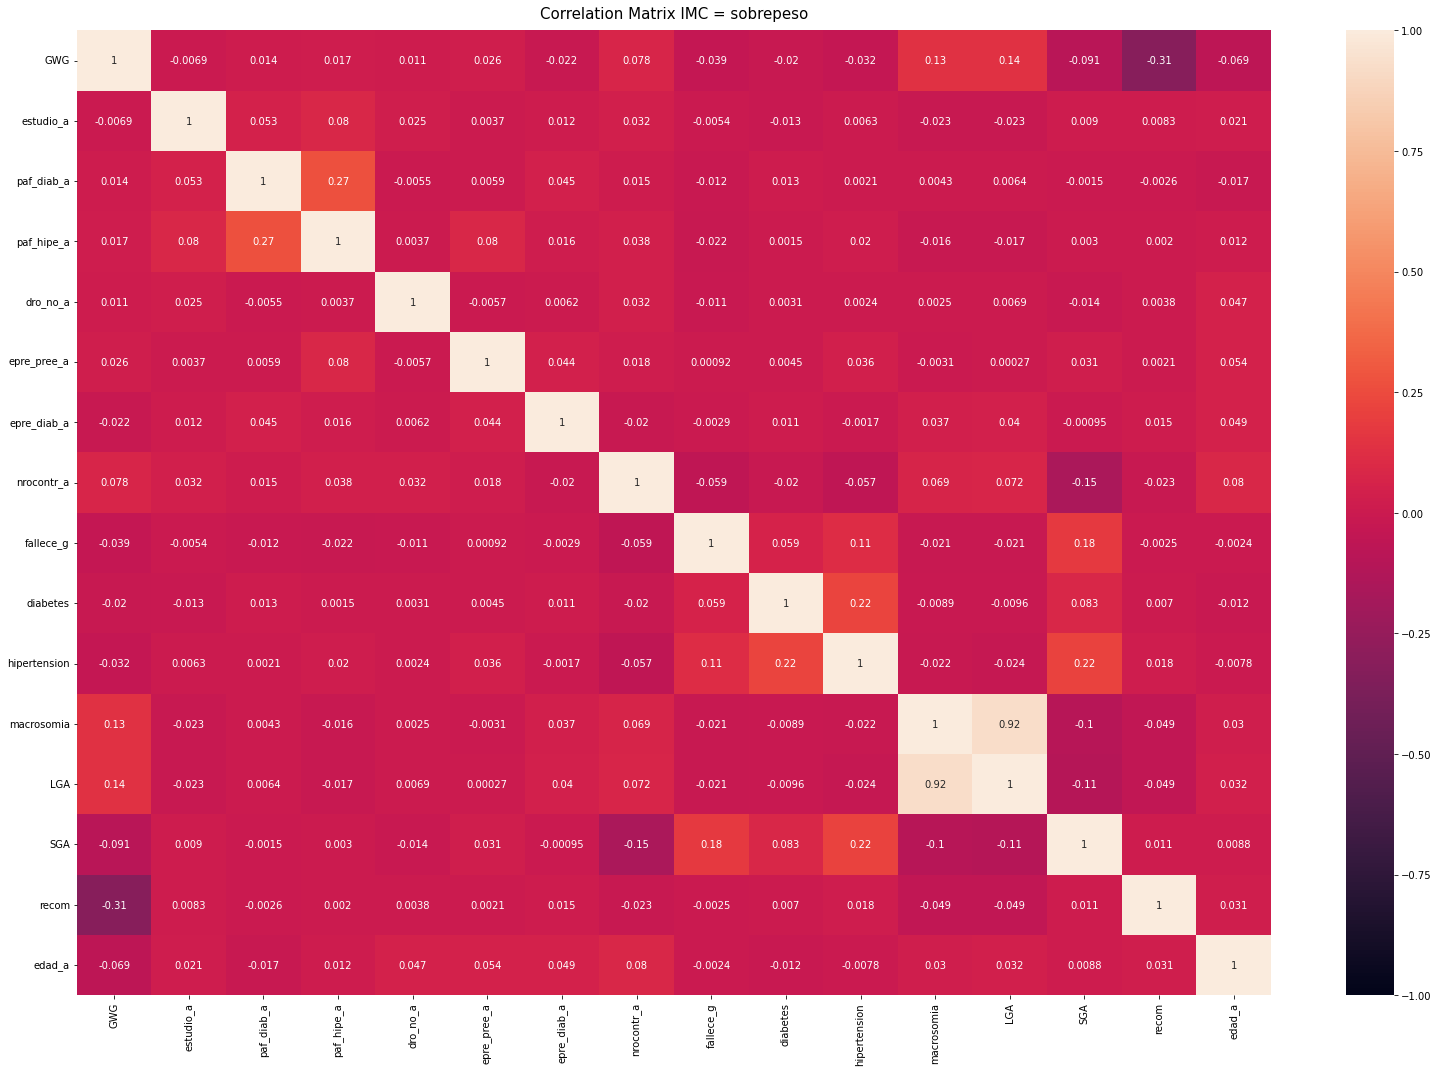

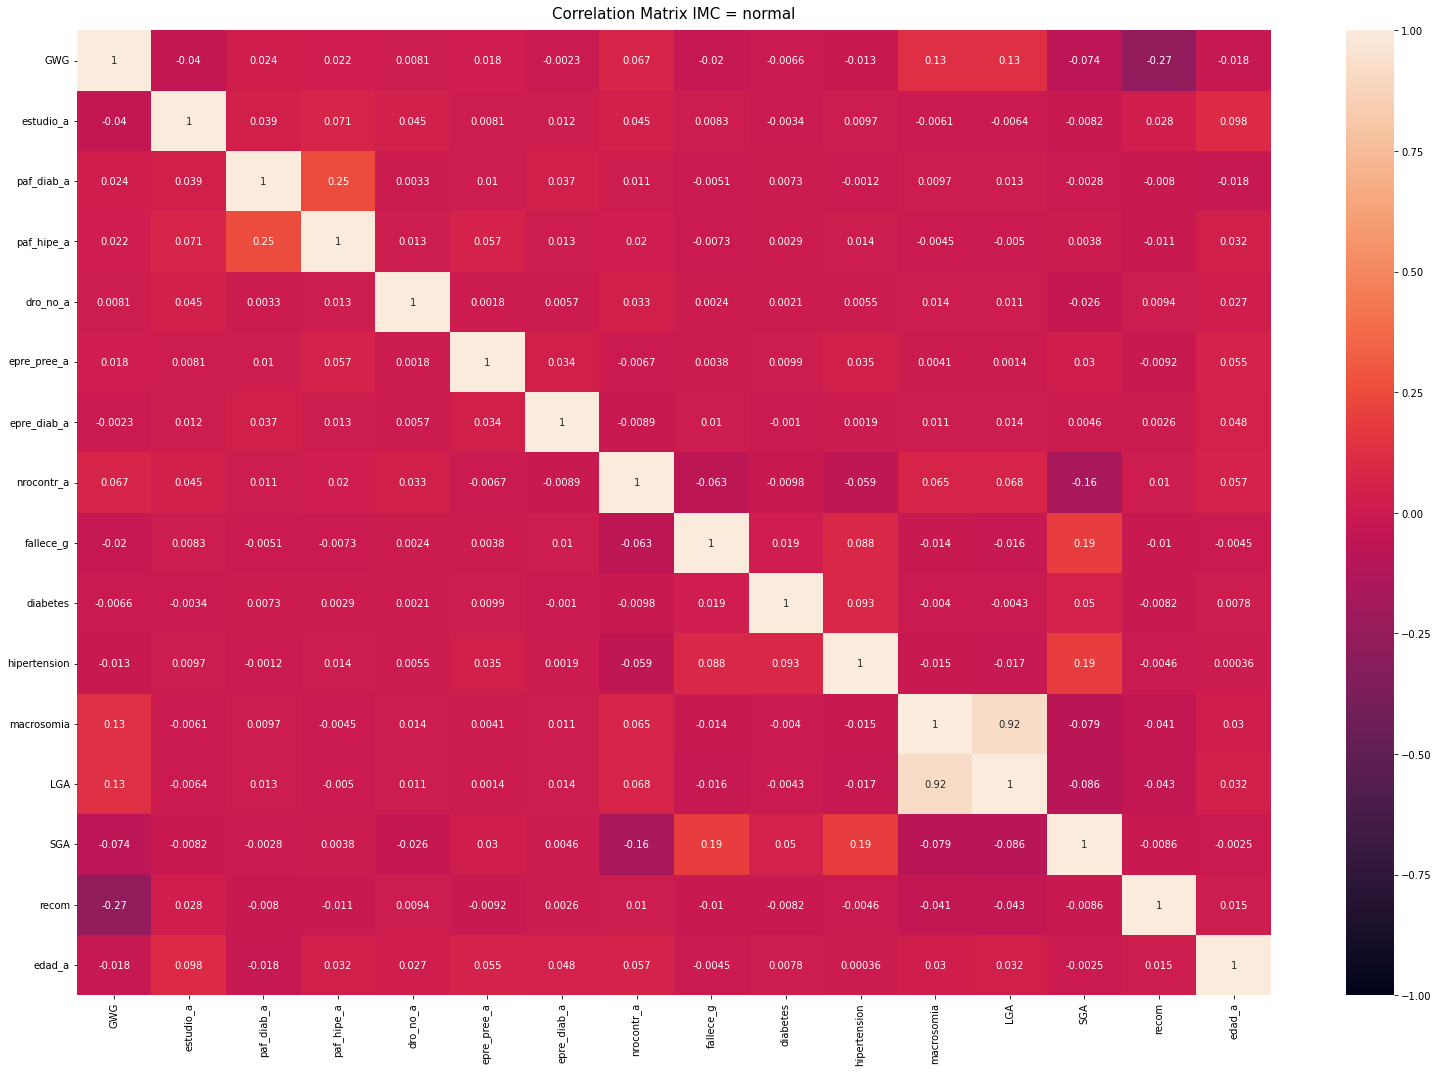

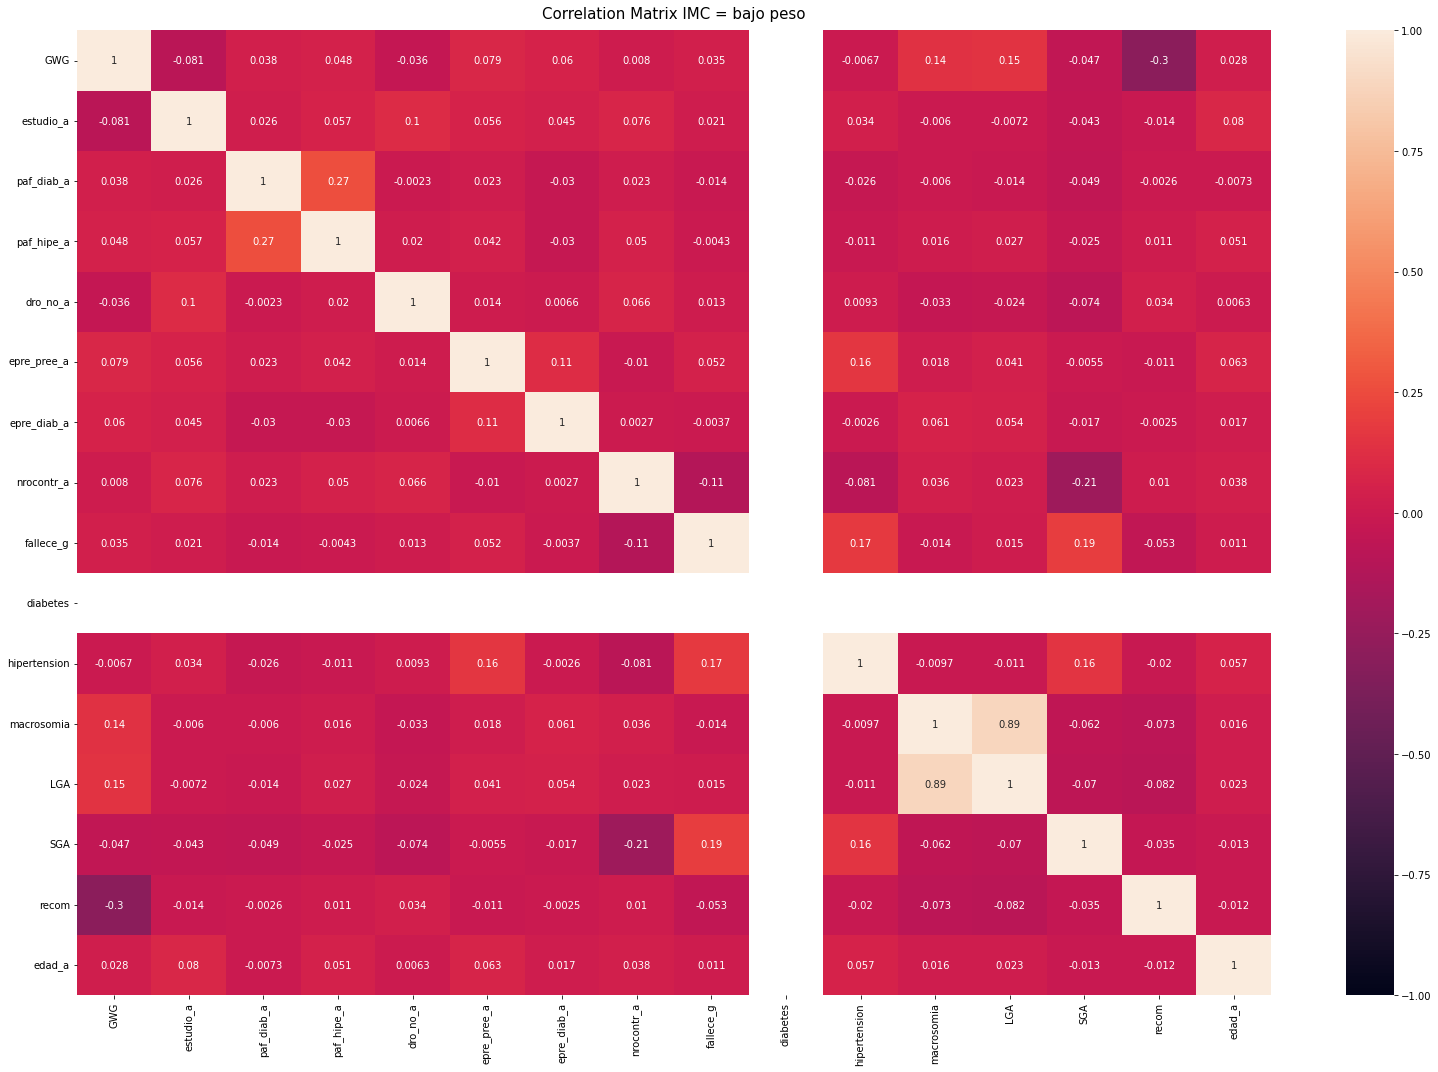

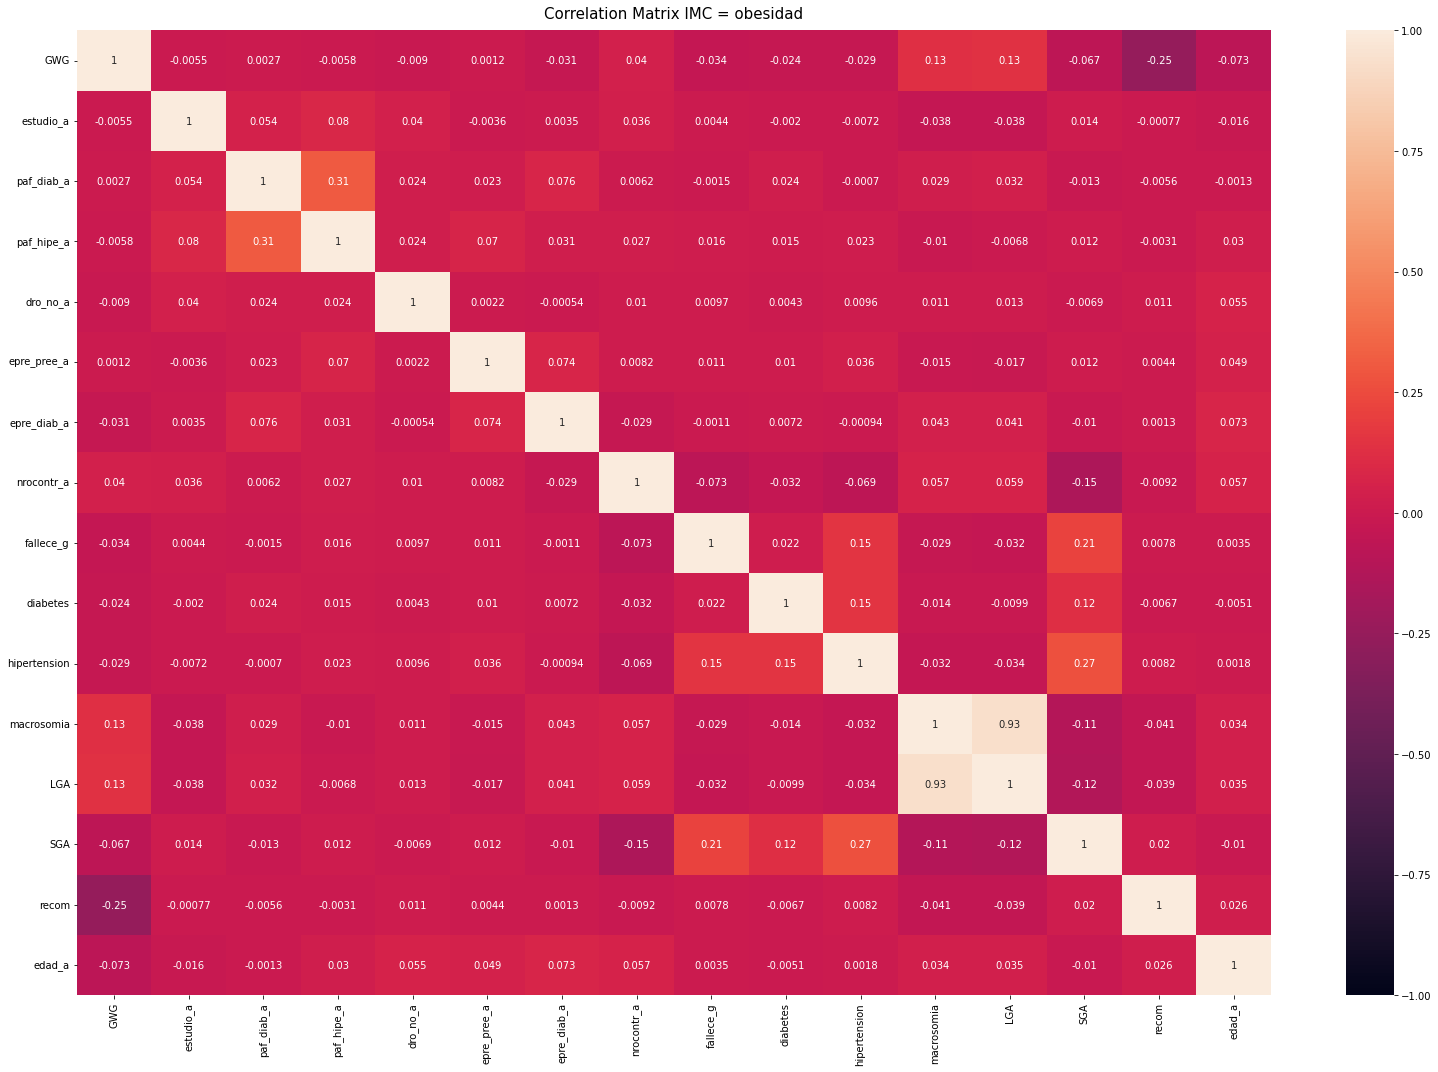

In [42]:
for imc in data_full["IMC"].unique():
    corr_mtx = data_full.loc[data_full["IMC"]==imc,corr_cols].corr()
    plot_corr(corr_mtx, title="Correlation Matrix IMC = {}".format(imc), path=main_path/"plots/corr_mtx_imc_{}.png".format(imc))

### Reflexión
Para la categoría obesidad, se observa una alta correlación positiva entre SGA con el fallecimiento del bebé, 
hipertensión con SGA. Por otro lado, se observa una correlación negativa de SGA con macrosomía y LGA, SGA con 
el número de controles.

Para la categoría sobrepeso, se observa una alta correlación positiva entre hipertensión con el fallecimiento 
del bebé, SGA con el fallecimiento del bebé e hipertención. Por otro lado, se observa una correlación negativa
de SGA con número de controles.

# Enfermedades por IMC y Recomendación

In [43]:
enf = ["LGA", "SGA", "diabetes", "hipertension", "macrosomia"] 
bys = ["IMC", "recom"]
data_full[enf]

,LGA,SGA,diabetes,hipertension,macrosomia
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,1,0,0,0,1
5,0,0,0,0,0
...,...,...,...,...,...
98717,0,1,0,0,0
98718,0,0,0,0,0
98720,0,1,0,0,0
98722,0,0,0,0,0


In [44]:
aux = data_full[enf].copy()
aux["Saludable"] = ~aux[enf].any(axis=1)
aux

,LGA,SGA,diabetes,hipertension,macrosomia,Saludable
1,0,0,0,0,0,True
2,0,0,0,0,0,True
3,0,0,0,0,0,True
4,1,0,0,0,1,False
5,0,0,0,0,0,True
...,...,...,...,...,...,...
98717,0,1,0,0,0,False
98718,0,0,0,0,0,True
98720,0,1,0,0,0,False
98722,0,0,0,0,0,True


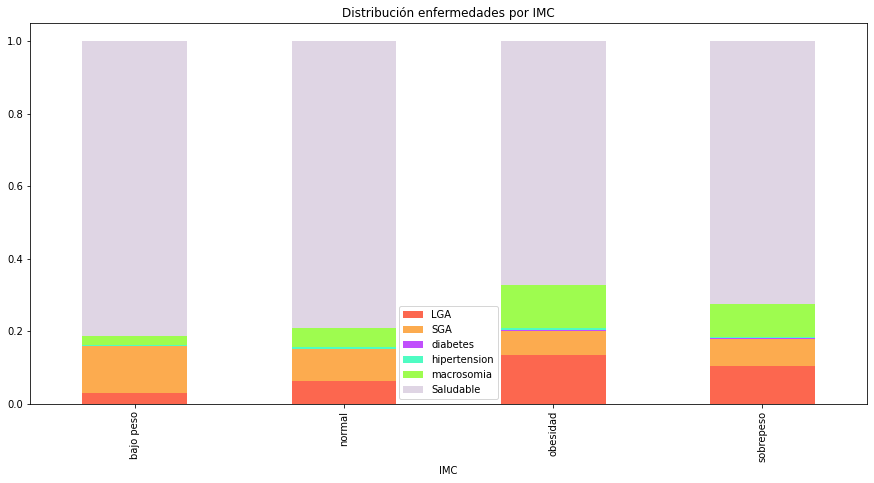

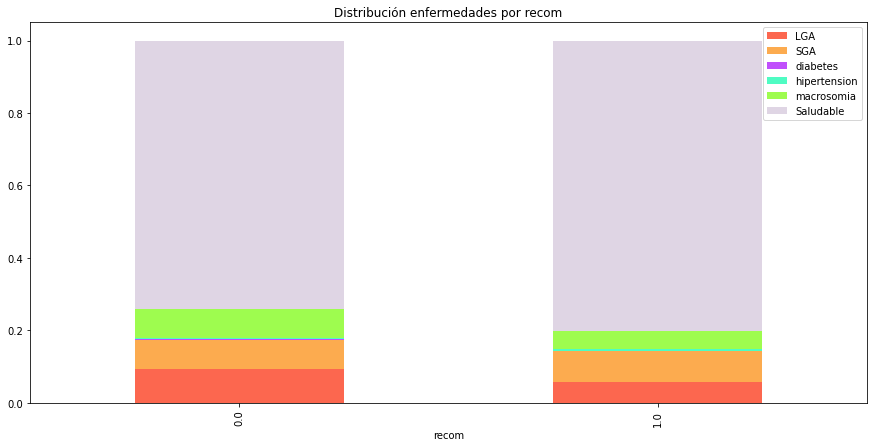

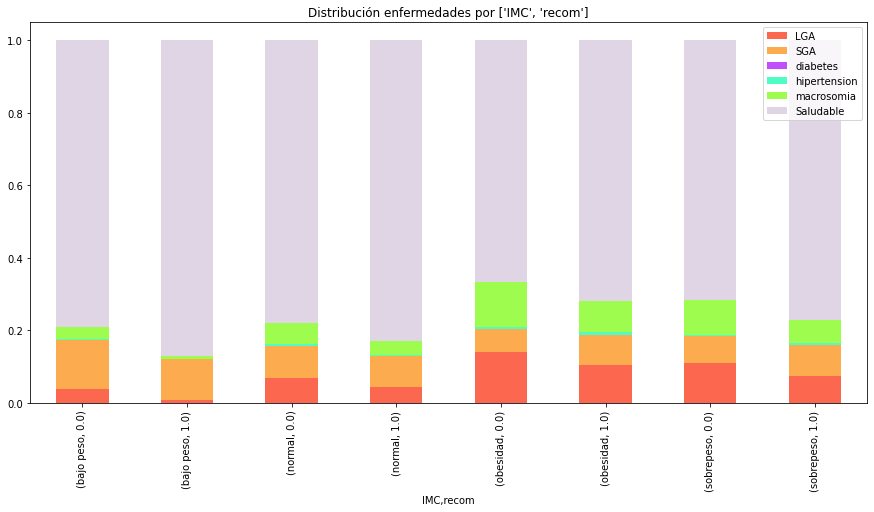

In [45]:
colors=["#FC674F", "#FCAB4F","#C04FFC" , "#4FFCC3", "#9EFC4F", "#DFD5E4"]

for b in ["IMC", "recom", ["IMC", "recom"]]:
    aux = data_full.copy()
    aux["Saludable"] = ~aux[enf].any(axis=1)

    data_stacked_bar= aux.groupby(b)[enf + ["Saludable"]].sum()
    data_stacked_bar["tot"] = data_stacked_bar.sum(axis=1)
    for c in data_stacked_bar.columns:
        if c == "tot":
            continue
        data_stacked_bar[c] = data_stacked_bar[c]/data_stacked_bar["tot"] 
    data_stacked_bar.drop(columns=["tot"], inplace=True)
    data_stacked_bar.plot(kind="bar", stacked=True, figsize=(15,7), color=colors,
                         title="Distribución enfermedades por {}".format(b))

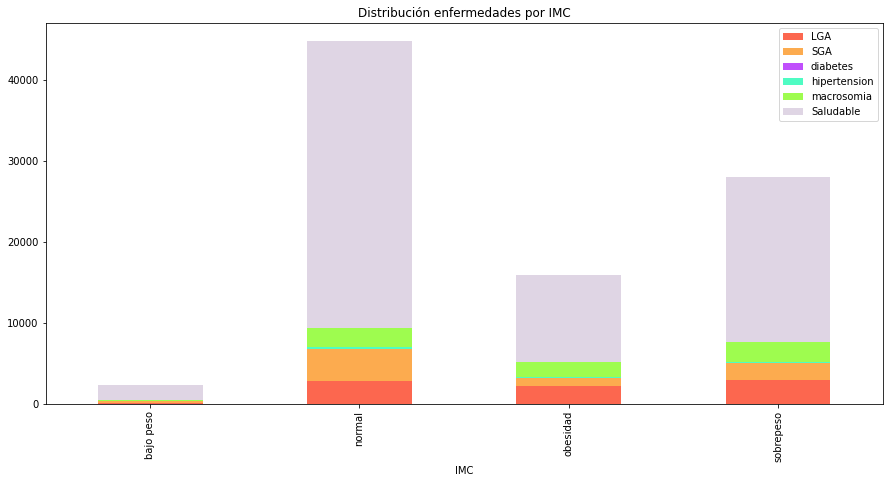

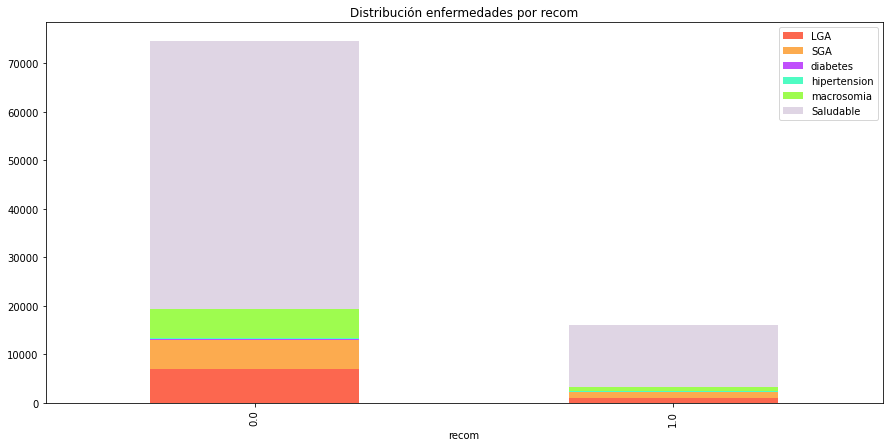

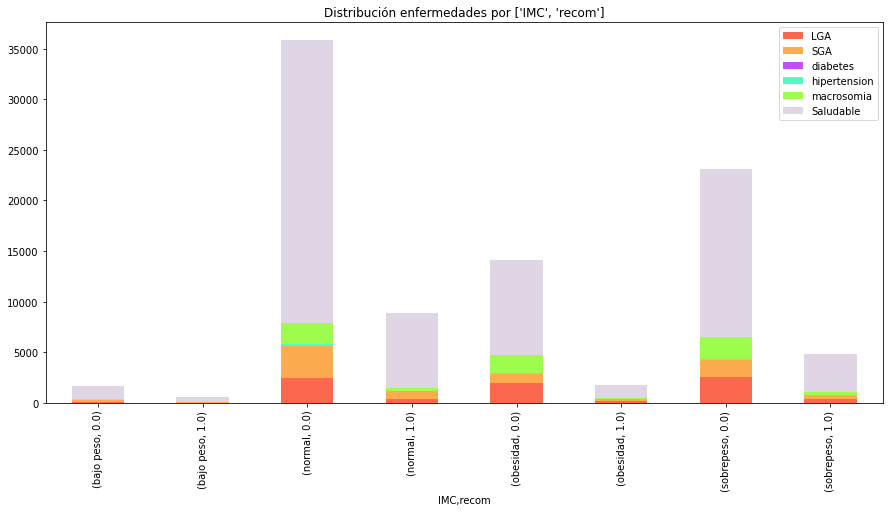

In [245]:
colors=["#FC674F", "#FCAB4F","#C04FFC" , "#4FFCC3", "#9EFC4F", "#DFD5E4"]

for b in ["IMC", "recom", ["IMC", "recom"]]:
    aux = data_full.copy()
    aux["Saludable"] = ~aux[enf].any(axis=1)

    data_stacked_bar= aux.groupby(b)[enf + ["Saludable"]].sum()
    data_stacked_bar["tot"] = data_stacked_bar.sum(axis=1)
    data_stacked_bar.drop(columns=["tot"], inplace=True)
    data_stacked_bar.plot(kind="bar", stacked=True, figsize=(15,7), color=colors,
                         title="Distribución enfermedades por {}".format(b))

# Enfermedades Bebé por IMC y Recomendación

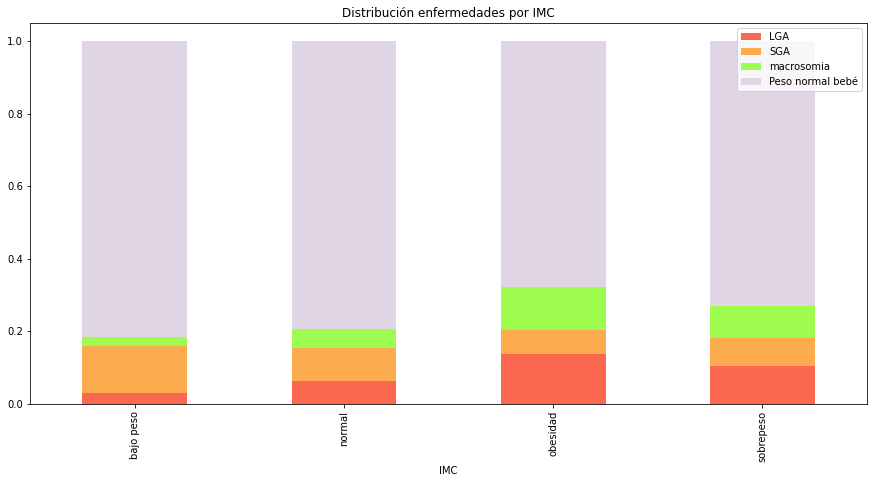

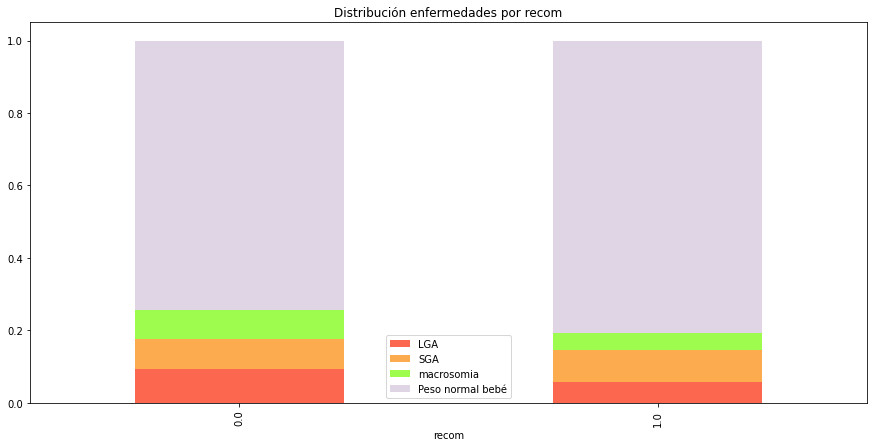

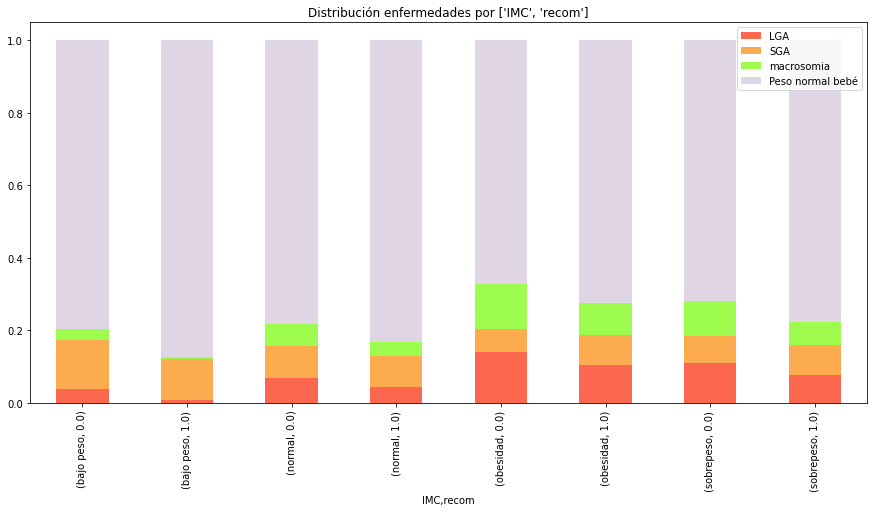

In [46]:
colors=["#FC674F", "#FCAB4F", "#9EFC4F", "#DFD5E4"]
enf2 = [x for x in enf if not x in  ["diabetes", "hipertension"]]

for b in ["IMC", "recom", ["IMC", "recom"]]:
    aux = data_full.copy()
    aux["Peso normal bebé"] = ~aux[enf2].any(axis=1)

    data_stacked_bar= aux.groupby(b)[enf2 + ["Peso normal bebé"]].sum()
    data_stacked_bar["tot"] = data_stacked_bar.sum(axis=1)
    for c in data_stacked_bar.columns:
        if c == "tot":
            continue
        data_stacked_bar[c] = data_stacked_bar[c]/data_stacked_bar["tot"] 
    data_stacked_bar.drop(columns=["tot"], inplace=True)
    data_stacked_bar.plot(kind="bar", stacked=True, figsize=(15,7), color=colors,
                         title="Distribución enfermedades por {}".format(b))

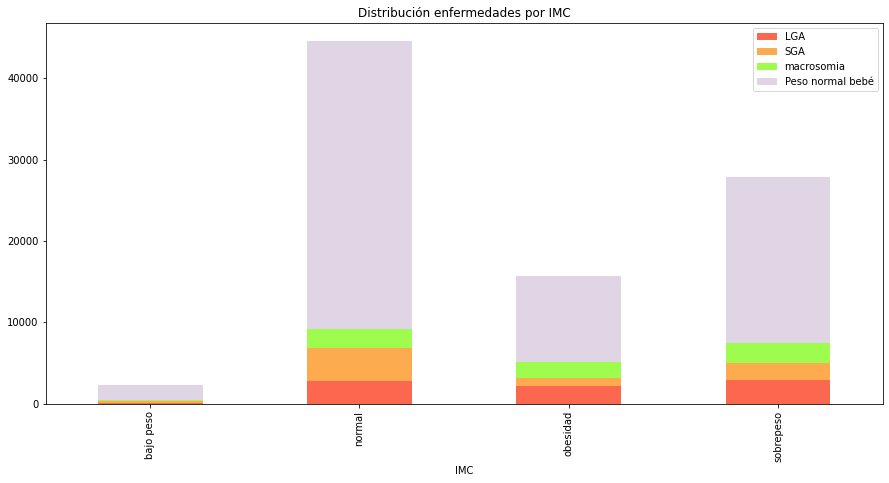

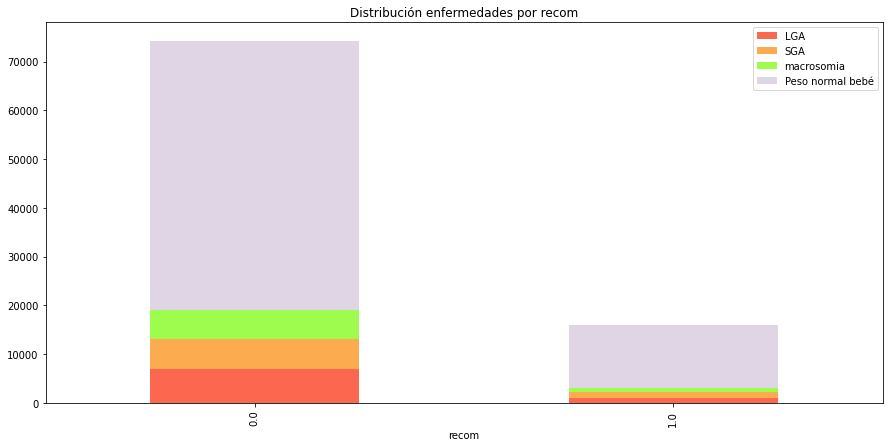

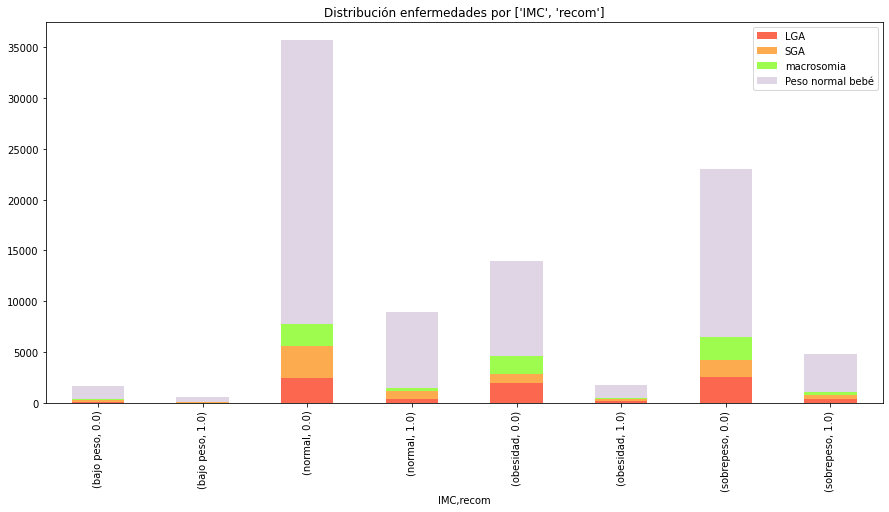

In [47]:
colors=["#FC674F", "#FCAB4F", "#9EFC4F", "#DFD5E4"]
enf2 = [x for x in enf if not x in  ["diabetes", "hipertension"]]

for b in ["IMC", "recom", ["IMC", "recom"]]:
    aux = data_full.copy()
    aux["Peso normal bebé"] = ~aux[enf2].any(axis=1)

    data_stacked_bar= aux.groupby(b)[enf2 + ["Peso normal bebé"]].sum()
    data_stacked_bar["tot"] = data_stacked_bar.sum(axis=1)

    data_stacked_bar.drop(columns=["tot"], inplace=True)
    data_stacked_bar.plot(kind="bar", stacked=True, figsize=(15,7), color=colors,
                         title="Distribución enfermedades por {}".format(b))

# Modelo Logit por Variable

In [250]:
feats = ["recom", "IMC", "GWG" ,"estudio_a", "dro_no_a", "epre_pree_a", "epre_diab_a", "nrocontr_a", "fallece_g", "edad_a"]
data_logit = data_full.copy()
data_logit = pd.get_dummies(data_logit, columns=["IMC"], drop_first=True)
final_tables={}
prv_tg=enf[0]
for tg in enf:
    final_table=pd.DataFrame()
    for f in feats:
        print("="*100)
        print("target: {} & feature: {}".format(tg,f))
        X = data_logit[[c for c in data_logit.columns if c.startswith(f)]]
        y = data_logit[tg]
        log_reg = sm.Logit(y, X).fit(maxiter=1000, method="bfgs")
        results_summary = log_reg.summary()
        results_summary = results_summary.tables[1].as_html()
        pd_table = pd.read_html(results_summary, header=0, index_col=0)[0]
        
        if final_table.empty:
            final_table = pd_table.T
        else:
            final_table = final_table.join(pd_table.T)
    display(final_table)
    final_tables[tg] = final_table 
        



target: LGA & feature: recom
Optimization terminated successfully.
         Current function value: 0.608809
         Iterations: 7
         Function evaluations: 9
         Gradient evaluations: 9
target: LGA & feature: IMC
Optimization terminated successfully.
         Current function value: 0.320885
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
target: LGA & feature: GWG
Optimization terminated successfully.
         Current function value: 0.384278
         Iterations: 8
         Function evaluations: 10
         Gradient evaluations: 10
target: LGA & feature: estudio_a
Optimization terminated successfully.
         Current function value: 0.330330
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
target: LGA & feature: dro_no_a
Optimization terminated successfully.
         Current function value: 0.320274
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
ta

,recom,IMC_normal,IMC_obesidad,IMC_sobrepeso,GWG,estudio_a,dro_no_a,epre_pree_a,epre_diab_a,nrocontr_a,fallece_g,edad_a
coef,-2.7229,-2.6431,-1.6989,-2.0433,-0.1418,-0.8002,-2.2521,-2.1452,-1.2948,-0.2686,-4.0286,-0.0756
std err,0.0340,0.0200,0.0240,0.0200,0.0010,0.0040,0.0120,0.0720,0.0850,0.0020,0.3520,0.0000
z,-80.8770,-135.1520,-72.2760,-103.5930,-168.2480,-180.7430,-189.4790,-29.7910,-15.1780,-173.6210,-11.4360,-176.5880
P>|z|,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
[0.025,-2.7890,-2.6810,-1.7450,-2.0820,-0.1430,-0.8090,-2.2750,-2.2860,-1.4620,-0.2720,-4.7190,-0.0760
0.975],-2.6570,-2.6050,-1.6530,-2.0050,-0.1400,-0.7920,-2.2290,-2.0040,-1.1280,-0.2660,-3.3380,-0.0750


target: SGA & feature: recom
Optimization terminated successfully.
         Current function value: 0.622136
         Iterations: 7
         Function evaluations: 9
         Gradient evaluations: 9
target: SGA & feature: IMC
Optimization terminated successfully.
         Current function value: 0.307726
         Iterations: 19
         Function evaluations: 21
         Gradient evaluations: 21
target: SGA & feature: GWG
Optimization terminated successfully.
         Current function value: 0.324124
         Iterations: 7
         Function evaluations: 10
         Gradient evaluations: 10
target: SGA & feature: estudio_a
Optimization terminated successfully.
         Current function value: 0.321855
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
target: SGA & feature: dro_no_a
Optimization terminated successfully.
         Current function value: 0.304705
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
ta

,recom,IMC_normal,IMC_obesidad,IMC_sobrepeso,GWG,estudio_a,dro_no_a,epre_pree_a,epre_diab_a,nrocontr_a,fallece_g,edad_a
coef,-2.3039,-2.2572,-2.5017,-2.3992,-0.1688,-0.8177,-2.3349,-1.9145,-2.4575,-0.3303,1.4625,-0.0811
std err,0.0280,0.0170,0.0320,0.0230,0.0010,0.0050,0.0120,0.0660,0.1300,0.0020,0.1180,0.0000
z,-81.7580,-135.7380,-77.8880,-105.4300,-170.0690,-180.9400,-189.9150,-29.0480,-18.9010,-173.7400,12.3770,-177.5900
P>|z|,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
[0.025,-2.3590,-2.2900,-2.5650,-2.4440,-0.1710,-0.8270,-2.3590,-2.0440,-2.7120,-0.3340,1.2310,-0.0820
0.975],-2.2490,-2.2250,-2.4390,-2.3550,-0.1670,-0.8090,-2.3110,-1.7850,-2.2030,-0.3270,1.6940,-0.0800


target: diabetes & feature: recom
Optimization terminated successfully.
         Current function value: 0.567177
         Iterations: 12
         Function evaluations: 14
         Gradient evaluations: 14
target: diabetes & feature: IMC
Optimization terminated successfully.
         Current function value: 0.022821
         Iterations: 46
         Function evaluations: 48
         Gradient evaluations: 48
target: diabetes & feature: GWG
Optimization terminated successfully.
         Current function value: 0.010082
         Iterations: 6
         Function evaluations: 10
         Gradient evaluations: 10
target: diabetes & feature: estudio_a
Optimization terminated successfully.
         Current function value: 0.014861
         Iterations: 12
         Function evaluations: 13
         Gradient evaluations: 13
target: diabetes & feature: dro_no_a
Optimization terminated successfully.
         Current function value: 0.015638
         Iterations: 13
         Function evaluations: 14
  

,recom,IMC_normal,IMC_obesidad,IMC_sobrepeso,GWG,estudio_a,dro_no_a,epre_pree_a,epre_diab_a,nrocontr_a,fallece_g,edad_a
coef,-7.7216,-8.2472,-6.6362,-7.2521,-1.3063,-3.5192,-7.4624,-6.1003,-5.7925,-2.1398,-4.4417,-0.3097
std err,0.3850,0.3010,0.2350,0.2360,0.0350,0.0780,0.1460,0.4670,0.6370,0.0550,0.4310,0.0060
z,-20.0670,-27.4050,-28.2480,-30.6900,-37.7990,-45.3310,-51.2420,-13.0690,-9.1000,-38.8450,-10.3170,-49.8980
P>|z|,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
[0.025,-8.4760,-8.8370,-7.0970,-7.7150,-1.3740,-3.6710,-7.7480,-7.0150,-7.0400,-2.2480,-5.2850,-0.3220
0.975],-6.9670,-7.6570,-6.1760,-6.7890,-1.2390,-3.3670,-7.1770,-5.1850,-4.5450,-2.0320,-3.5980,-0.2980


target: hipertension & feature: recom
Optimization terminated successfully.
         Current function value: 0.572146
         Iterations: 10
         Function evaluations: 12
         Gradient evaluations: 12
target: hipertension & feature: IMC
Optimization terminated successfully.
         Current function value: 0.046157
         Iterations: 34
         Function evaluations: 36
         Gradient evaluations: 36
target: hipertension & feature: GWG
Optimization terminated successfully.
         Current function value: 0.045598
         Iterations: 6
         Function evaluations: 10
         Gradient evaluations: 10
target: hipertension & feature: estudio_a
Optimization terminated successfully.
         Current function value: 0.044150
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
target: hipertension & feature: dro_no_a
Optimization terminated successfully.
         Current function value: 0.039362
         Iterations: 11
         Function

,recom,IMC_normal,IMC_obesidad,IMC_sobrepeso,GWG,estudio_a,dro_no_a,epre_pree_a,epre_diab_a,nrocontr_a,fallece_g,edad_a
coef,-5.3198,-5.5259,-5.0525,-5.4315,-0.5629,-2.1767,-5.3934,-3.8605,-5.2602,-1.0669,-2.1677,-0.2105
std err,0.1160,0.0770,0.1070,0.0950,0.0070,0.0220,0.0520,0.1550,0.4890,0.0140,0.1520,0.0020
z,-45.7390,-71.3240,-47.2360,-56.9120,-85.3990,-98.1080,-103.7930,-24.8770,-10.7600,-75.7360,-14.2500,-99.6050
P>|z|,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
[0.025,-5.5480,-5.6780,-5.2620,-5.6190,-0.5760,-2.2200,-5.4950,-4.1650,-6.2180,-1.0940,-2.4660,-0.2150
0.975],-5.0920,-5.3740,-4.8430,-5.2440,-0.5500,-2.1330,-5.2920,-3.5560,-4.3020,-1.0390,-1.8700,-0.2060


target: macrosomia & feature: recom
Optimization terminated successfully.
         Current function value: 0.603687
         Iterations: 7
         Function evaluations: 9
         Gradient evaluations: 9
target: macrosomia & feature: IMC
Optimization terminated successfully.
         Current function value: 0.292564
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
target: macrosomia & feature: GWG
Optimization terminated successfully.
         Current function value: 0.355219
         Iterations: 7
         Function evaluations: 9
         Gradient evaluations: 9
target: macrosomia & feature: estudio_a
Optimization terminated successfully.
         Current function value: 0.301457
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
target: macrosomia & feature: dro_no_a
Optimization terminated successfully.
         Current function value: 0.291159
         Iterations: 7
         Function evaluations: 8
  

,recom,IMC_normal,IMC_obesidad,IMC_sobrepeso,GWG,estudio_a,dro_no_a,epre_pree_a,epre_diab_a,nrocontr_a,fallece_g,edad_a
coef,-2.9093,-2.8081,-1.8441,-2.205,-0.1543,-0.8613,-2.4093,-2.2975,-1.4387,-0.2909,-4.2886,-0.0815
std err,0.0370,0.0210,0.0250,0.021,0.0010,0.0050,0.0130,0.0770,0.0890,0.0020,0.4000,0.0000
z,-79.5570,-133.5680,-74.5170,-104.905,-169.7240,-181.0090,-190.0130,-30.0110,-16.1590,-174.5980,-10.7330,-177.6240
P>|z|,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
[0.025,-2.9810,-2.8490,-1.8930,-2.246,-0.1560,-0.8710,-2.4340,-2.4480,-1.6130,-0.2940,-5.0720,-0.0820
0.975],-2.8380,-2.7670,-1.7960,-2.164,-0.1530,-0.8520,-2.3840,-2.1470,-1.2640,-0.2880,-3.5050,-0.0810


# Importancia Variables modelo Logit

In [252]:
data_logit = data_full.copy()
data_logit = pd.get_dummies(data_logit, columns=["IMC"], drop_first=True)

# logit_cols_sfx = ["recom", "feching_a","fechnac_a","paf_otrc_a","dro_otrc_a","otr_anti_a", "pesonorm_a","fur_a","fecha_b","copr_spa_b","copr_mam_b","copr_car_b","copr_gin_b","diastoli_b","sistolic_b","pulso_b","pesoactu_b","tempax_b","excabcue_b","excardio_b","exabdome_b","exextrem_b","exgenita_b","exmamas_b","altuteri_b","pesofeta_b","excervic_b","dilatace_b","movfetal_b","pesonac_g","tallanac_g","lecherec_g"]
# logit_cols =  ["LGA", "SGA", "diabetes", "hipertension", "macrosomia", "IMC", "GWG", "recom"] 
# to_drop_aux = ['excardio_b_3', 'exmamas_b_3',"IMC_sobrepeso", "exgenita_b_3"]
cols1 = ["IMC", "GWG" ,"estudio_a", "dro_no_a", "epre_pree_a", "epre_diab_a", "nrocontr_a", "fallece_g", "edad_a"]
cols2 = ["recom","estudio_a", "dro_no_a", "epre_pree_a", "epre_diab_a", "nrocontr_a", "fallece_g", "edad_a"]
cols1_ = []
cols2_ = []
for c1 in data_logit.columns:
    for c2 in cols1:
        if c1.startswith(c2):
            cols1_.append(c1)
for c1 in data_logit.columns:
    for c2 in cols2:
        if c1.startswith(c2):
            cols2_.append(c1)
            

# data_logit = data_full[logit_cols]
# data_logit["talla_a"] = data_logit["talla_a"].apply(lambda talla_a: int(str(talla_a).replace(",", ".").replace(" ", "")))

#upper_tri = data_logit.corr().abs().where(np.triu(np.ones(data_logit.corr().shape), k=1).astype(bool))
#to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]
# print(to_drop)
#data_logit.drop(columns=to_drop,inplace=True)

for e in enf:
    for s in (cols1_,cols2_):
        aux_txt = "recomendación" if "recom" in s else "IMC/GWG"
        X = data_logit[s]
        y = data_logit[e]
        display(X)
        # display(X.head())
        log_reg = sm.Logit(y, X).fit(maxiter=1000, method="bfgs")
        results_summary = log_reg.summary()
        results_as_html = results_summary.tables[1].as_html()
        results_as_df = pd.read_html(results_as_html, header=0, index_col=0)[0].sort_values("P>|z|") 
        print("\n Modelo: {} & {}".format(e,aux_txt))
        display(results_summary.tables[0])
        display(results_as_df)

,edad_a,estudio_a,dro_no_a,epre_pree_a,epre_diab_a,nrocontr_a,fallece_g,GWG,IMC_normal,IMC_obesidad,IMC_sobrepeso
1,24.0,3.0,1,0,0,6.0,0,9.0,0,0,1
2,28.0,3.0,1,0,0,12.0,0,15.0,1,0,0
3,24.0,4.0,1,0,0,6.0,0,17.0,1,0,0
4,25.0,3.0,1,0,0,6.0,0,17.0,1,0,0
5,22.0,3.0,1,0,0,12.0,0,24.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
98717,38.0,3.0,1,0,0,13.0,0,16.0,0,1,0
98718,26.0,5.0,1,0,0,10.0,0,16.0,0,1,0
98720,22.0,3.0,1,0,0,7.0,0,8.0,1,0,0
98722,58.0,2.0,1,0,0,10.0,0,20.0,0,1,0


Optimization terminated successfully.
         Current function value: 0.305368
         Iterations: 82
         Function evaluations: 85
         Gradient evaluations: 85

 Modelo: LGA & IMC/GWG


Dep. Variable:,LGA,No. Observations:,83513
Model:,Logit,Df Residuals:,83502
Method:,MLE,Df Model:,10
Date:,"Wed, 24 Aug 2022",Pseudo R-squ.:,0.02570
Time:,23:21:23,Log-Likelihood:,-25502.
converged:,True,LL-Null:,-26175.
Covariance Type:,nonrobust,LLR p-value:,6.388e-283


,coef,std err,z,P>|z|,[0.025,0.975]
estudio_a,-0.2536,0.013,-19.101,0.000,-0.280,-0.228
dro_no_a,-1.7389,0.051,-34.020,0.000,-1.839,-1.639
epre_diab_a,0.8319,0.089,9.335,0.000,0.657,1.007
nrocontr_a,0.0298,0.003,9.087,0.000,0.023,0.036
fallece_g,-1.7759,0.359,-4.944,0.000,-2.480,-1.072
GWG,0.0401,0.002,25.024,0.000,0.037,0.043
IMC_normal,-1.1735,0.049,-23.824,0.000,-1.270,-1.077
IMC_sobrepeso,-0.4827,0.051,-9.548,0.000,-0.582,-0.384
epre_pree_a,-0.1721,0.075,-2.283,0.022,-0.320,-0.024
IMC_obesidad,-0.0787,0.053,-1.496,0.135,-0.182,0.024


,edad_a,estudio_a,dro_no_a,epre_pree_a,epre_diab_a,nrocontr_a,fallece_g,recom
1,24.0,3.0,1,0,0,6.0,0,1.0
2,28.0,3.0,1,0,0,12.0,0,0.0
3,24.0,4.0,1,0,0,6.0,0,0.0
4,25.0,3.0,1,0,0,6.0,0,0.0
5,22.0,3.0,1,0,0,12.0,0,0.0
...,...,...,...,...,...,...,...,...
98717,38.0,3.0,1,0,0,13.0,0,0.0
98718,26.0,5.0,1,0,0,10.0,0,0.0
98720,22.0,3.0,1,0,0,7.0,0,0.0
98722,58.0,2.0,1,0,0,10.0,0,0.0


Optimization terminated successfully.
         Current function value: 0.313819
         Iterations: 66
         Function evaluations: 69
         Gradient evaluations: 69

 Modelo: LGA & recomendación


Dep. Variable:,LGA,No. Observations:,83513
Model:,Logit,Df Residuals:,83505
Method:,MLE,Df Model:,7
Date:,"Wed, 24 Aug 2022",Pseudo R-squ.:,-0.001265
Time:,23:21:23,Log-Likelihood:,-26208.
converged:,True,LL-Null:,-26175.
Covariance Type:,nonrobust,LLR p-value:,1.000


,coef,std err,z,P>|z|,[0.025,0.975]
edad_a,0.0046,0.001,4.190,0.000,0.002,0.007
estudio_a,-0.2908,0.013,-23.117,0.000,-0.315,-0.266
dro_no_a,-1.7495,0.043,-41.126,0.000,-1.833,-1.666
epre_diab_a,0.9679,0.088,11.008,0.000,0.796,1.140
nrocontr_a,0.0305,0.003,9.640,0.000,0.024,0.037
fallece_g,-1.8295,0.359,-5.097,0.000,-2.533,-1.126
recom,-0.6082,0.036,-16.836,0.000,-0.679,-0.537
epre_pree_a,-0.0234,0.075,-0.313,0.754,-0.169,0.123


,edad_a,estudio_a,dro_no_a,epre_pree_a,epre_diab_a,nrocontr_a,fallece_g,GWG,IMC_normal,IMC_obesidad,IMC_sobrepeso
1,24.0,3.0,1,0,0,6.0,0,9.0,0,0,1
2,28.0,3.0,1,0,0,12.0,0,15.0,1,0,0
3,24.0,4.0,1,0,0,6.0,0,17.0,1,0,0
4,25.0,3.0,1,0,0,6.0,0,17.0,1,0,0
5,22.0,3.0,1,0,0,12.0,0,24.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
98717,38.0,3.0,1,0,0,13.0,0,16.0,0,1,0
98718,26.0,5.0,1,0,0,10.0,0,16.0,0,1,0
98720,22.0,3.0,1,0,0,7.0,0,8.0,1,0,0
98722,58.0,2.0,1,0,0,10.0,0,20.0,0,1,0


Optimization terminated successfully.
         Current function value: 0.275488
         Iterations: 71
         Function evaluations: 75
         Gradient evaluations: 75

 Modelo: SGA & IMC/GWG


Dep. Variable:,SGA,No. Observations:,83513
Model:,Logit,Df Residuals:,83502
Method:,MLE,Df Model:,10
Date:,"Wed, 24 Aug 2022",Pseudo R-squ.:,0.08283
Time:,23:21:24,Log-Likelihood:,-23007.
converged:,True,LL-Null:,-25085.
Covariance Type:,nonrobust,LLR p-value:,0.000


,coef,std err,z,P>|z|,[0.025,0.975]
epre_pree_a,0.5225,0.071,7.368,0.000,0.384,0.662
nrocontr_a,-0.2000,0.005,-44.325,0.000,-0.209,-0.191
fallece_g,3.5276,0.124,28.358,0.000,3.284,3.771
GWG,-0.0367,0.002,-17.706,0.000,-0.041,-0.033
IMC_normal,-0.3388,0.060,-5.664,0.000,-0.456,-0.222
IMC_obesidad,-0.7960,0.067,-11.800,0.000,-0.928,-0.664
IMC_sobrepeso,-0.5547,0.063,-8.846,0.000,-0.678,-0.432
dro_no_a,-0.2179,0.067,-3.268,0.001,-0.349,-0.087
epre_diab_a,-0.3326,0.137,-2.421,0.015,-0.602,-0.063
edad_a,0.0030,0.001,2.391,0.017,0.001,0.006


,edad_a,estudio_a,dro_no_a,epre_pree_a,epre_diab_a,nrocontr_a,fallece_g,recom
1,24.0,3.0,1,0,0,6.0,0,1.0
2,28.0,3.0,1,0,0,12.0,0,0.0
3,24.0,4.0,1,0,0,6.0,0,0.0
4,25.0,3.0,1,0,0,6.0,0,0.0
5,22.0,3.0,1,0,0,12.0,0,0.0
...,...,...,...,...,...,...,...,...
98717,38.0,3.0,1,0,0,13.0,0,0.0
98718,26.0,5.0,1,0,0,10.0,0,0.0
98720,22.0,3.0,1,0,0,7.0,0,0.0
98722,58.0,2.0,1,0,0,10.0,0,0.0


Optimization terminated successfully.
         Current function value: 0.278385
         Iterations: 63
         Function evaluations: 66
         Gradient evaluations: 66

 Modelo: SGA & recomendación


Dep. Variable:,SGA,No. Observations:,83513
Model:,Logit,Df Residuals:,83505
Method:,MLE,Df Model:,7
Date:,"Wed, 24 Aug 2022",Pseudo R-squ.:,0.07318
Time:,23:21:24,Log-Likelihood:,-23249.
converged:,True,LL-Null:,-25085.
Covariance Type:,nonrobust,LLR p-value:,0.000


,coef,std err,z,P>|z|,[0.025,0.975]
dro_no_a,-0.8310,0.048,-17.192,0.000,-0.926,-0.736
epre_pree_a,0.4391,0.071,6.210,0.000,0.301,0.578
nrocontr_a,-0.2156,0.004,-49.311,0.000,-0.224,-0.207
fallece_g,3.5193,0.124,28.457,0.000,3.277,3.762
epre_diab_a,-0.4005,0.138,-2.906,0.004,-0.671,-0.130
edad_a,-0.0018,0.001,-1.518,0.129,-0.004,0.001
recom,0.0292,0.032,0.907,0.365,-0.034,0.092
estudio_a,-0.0065,0.014,-0.473,0.636,-0.033,0.020


,edad_a,estudio_a,dro_no_a,epre_pree_a,epre_diab_a,nrocontr_a,fallece_g,GWG,IMC_normal,IMC_obesidad,IMC_sobrepeso
1,24.0,3.0,1,0,0,6.0,0,9.0,0,0,1
2,28.0,3.0,1,0,0,12.0,0,15.0,1,0,0
3,24.0,4.0,1,0,0,6.0,0,17.0,1,0,0
4,25.0,3.0,1,0,0,6.0,0,17.0,1,0,0
5,22.0,3.0,1,0,0,12.0,0,24.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
98717,38.0,3.0,1,0,0,13.0,0,16.0,0,1,0
98718,26.0,5.0,1,0,0,10.0,0,16.0,0,1,0
98720,22.0,3.0,1,0,0,7.0,0,8.0,1,0,0
98722,58.0,2.0,1,0,0,10.0,0,20.0,0,1,0


Optimization terminated successfully.
         Current function value: 0.004335
         Iterations: 130
         Function evaluations: 139
         Gradient evaluations: 139

 Modelo: diabetes & IMC/GWG


Dep. Variable:,diabetes,No. Observations:,83513
Model:,Logit,Df Residuals:,83502
Method:,MLE,Df Model:,10
Date:,"Wed, 24 Aug 2022",Pseudo R-squ.:,0.09188
Time:,23:21:25,Log-Likelihood:,-362.04
converged:,True,LL-Null:,-398.67
Covariance Type:,nonrobust,LLR p-value:,1.037e-11


,coef,std err,z,P>|z|,[0.025,0.975]
nrocontr_a,-0.2686,0.052,-5.160,0.000,-0.371,-0.167
fallece_g,1.7740,0.495,3.580,0.000,0.803,2.745
GWG,-0.1467,0.028,-5.200,0.000,-0.202,-0.091
IMC_normal,-2.0691,0.503,-4.112,0.000,-3.055,-1.083
estudio_a,-0.4217,0.143,-2.949,0.003,-0.702,-0.141
IMC_sobrepeso,-1.3067,0.471,-2.776,0.005,-2.229,-0.384
dro_no_a,-1.1624,0.480,-2.420,0.016,-2.104,-0.221
IMC_obesidad,-1.1174,0.482,-2.320,0.020,-2.061,-0.173
epre_pree_a,1.0816,0.538,2.011,0.044,0.027,2.136
edad_a,-0.0213,0.012,-1.796,0.072,-0.045,0.002


,edad_a,estudio_a,dro_no_a,epre_pree_a,epre_diab_a,nrocontr_a,fallece_g,recom
1,24.0,3.0,1,0,0,6.0,0,1.0
2,28.0,3.0,1,0,0,12.0,0,0.0
3,24.0,4.0,1,0,0,6.0,0,0.0
4,25.0,3.0,1,0,0,6.0,0,0.0
5,22.0,3.0,1,0,0,12.0,0,0.0
...,...,...,...,...,...,...,...,...
98717,38.0,3.0,1,0,0,13.0,0,0.0
98718,26.0,5.0,1,0,0,10.0,0,0.0
98720,22.0,3.0,1,0,0,7.0,0,0.0
98722,58.0,2.0,1,0,0,10.0,0,0.0


Optimization terminated successfully.
         Current function value: 0.004800
         Iterations: 69
         Function evaluations: 78
         Gradient evaluations: 78

 Modelo: diabetes & recomendación


Dep. Variable:,diabetes,No. Observations:,83513
Model:,Logit,Df Residuals:,83505
Method:,MLE,Df Model:,7
Date:,"Wed, 24 Aug 2022",Pseudo R-squ.:,-0.005522
Time:,23:21:26,Log-Likelihood:,-400.87
converged:,True,LL-Null:,-398.67
Covariance Type:,nonrobust,LLR p-value:,1.000


,coef,std err,z,P>|z|,[0.025,0.975]
edad_a,-0.0366,0.010,-3.804,0.000,-0.055,-0.018
estudio_a,-0.7852,0.112,-7.006,0.000,-1.005,-0.566
dro_no_a,-2.2473,0.291,-7.716,0.000,-2.818,-1.676
nrocontr_a,-0.4123,0.047,-8.809,0.000,-0.504,-0.321
fallece_g,1.8681,0.481,3.881,0.000,0.925,2.812
epre_pree_a,1.1299,0.525,2.153,0.031,0.101,2.159
recom,-0.7248,0.460,-1.577,0.115,-1.626,0.176
epre_diab_a,0.6535,0.916,0.713,0.476,-1.143,2.450


,edad_a,estudio_a,dro_no_a,epre_pree_a,epre_diab_a,nrocontr_a,fallece_g,GWG,IMC_normal,IMC_obesidad,IMC_sobrepeso
1,24.0,3.0,1,0,0,6.0,0,9.0,0,0,1
2,28.0,3.0,1,0,0,12.0,0,15.0,1,0,0
3,24.0,4.0,1,0,0,6.0,0,17.0,1,0,0
4,25.0,3.0,1,0,0,6.0,0,17.0,1,0,0
5,22.0,3.0,1,0,0,12.0,0,24.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
98717,38.0,3.0,1,0,0,13.0,0,16.0,0,1,0
98718,26.0,5.0,1,0,0,10.0,0,16.0,0,1,0
98720,22.0,3.0,1,0,0,7.0,0,8.0,1,0,0
98722,58.0,2.0,1,0,0,10.0,0,20.0,0,1,0


Optimization terminated successfully.
         Current function value: 0.025464
         Iterations: 97
         Function evaluations: 109
         Gradient evaluations: 109

 Modelo: hipertension & IMC/GWG


Dep. Variable:,hipertension,No. Observations:,83513
Model:,Logit,Df Residuals:,83502
Method:,MLE,Df Model:,10
Date:,"Wed, 24 Aug 2022",Pseudo R-squ.:,0.1124
Time:,23:21:27,Log-Likelihood:,-2126.6
converged:,True,LL-Null:,-2395.9
Covariance Type:,nonrobust,LLR p-value:,2.279e-109


,coef,std err,z,P>|z|,[0.025,0.975]
dro_no_a,-1.0905,0.192,-5.676,0.000,-1.467,-0.714
epre_pree_a,1.5883,0.177,8.973,0.000,1.241,1.935
nrocontr_a,-0.3486,0.020,-17.836,0.000,-0.387,-0.310
fallece_g,2.3673,0.173,13.647,0.000,2.027,2.707
GWG,-0.0593,0.008,-7.194,0.000,-0.075,-0.043
IMC_normal,-1.2864,0.178,-7.211,0.000,-1.636,-0.937
IMC_obesidad,-1.1554,0.201,-5.745,0.000,-1.550,-0.761
IMC_sobrepeso,-1.2704,0.190,-6.692,0.000,-1.643,-0.898
edad_a,-0.0102,0.005,-2.172,0.030,-0.019,-0.001
epre_diab_a,-0.3819,0.474,-0.806,0.420,-1.311,0.547


,edad_a,estudio_a,dro_no_a,epre_pree_a,epre_diab_a,nrocontr_a,fallece_g,recom
1,24.0,3.0,1,0,0,6.0,0,1.0
2,28.0,3.0,1,0,0,12.0,0,0.0
3,24.0,4.0,1,0,0,6.0,0,0.0
4,25.0,3.0,1,0,0,6.0,0,0.0
5,22.0,3.0,1,0,0,12.0,0,0.0
...,...,...,...,...,...,...,...,...
98717,38.0,3.0,1,0,0,13.0,0,0.0
98718,26.0,5.0,1,0,0,10.0,0,0.0
98720,22.0,3.0,1,0,0,7.0,0,0.0
98722,58.0,2.0,1,0,0,10.0,0,0.0


Optimization terminated successfully.
         Current function value: 0.026260
         Iterations: 100
         Function evaluations: 112
         Gradient evaluations: 112

 Modelo: hipertension & recomendación


Dep. Variable:,hipertension,No. Observations:,83513
Model:,Logit,Df Residuals:,83505
Method:,MLE,Df Model:,7
Date:,"Wed, 24 Aug 2022",Pseudo R-squ.:,0.08468
Time:,23:21:27,Log-Likelihood:,-2193.1
converged:,True,LL-Null:,-2395.9
Covariance Type:,nonrobust,LLR p-value:,1.387e-83


,coef,std err,z,P>|z|,[0.025,0.975]
edad_a,-0.0213,0.004,-5.202,0.000,-0.029,-0.013
estudio_a,-0.2645,0.047,-5.576,0.000,-0.357,-0.171
dro_no_a,-1.9008,0.137,-13.915,0.000,-2.169,-1.633
epre_pree_a,1.5841,0.174,9.094,0.000,1.243,1.926
nrocontr_a,-0.4059,0.019,-21.889,0.000,-0.442,-0.370
fallece_g,2.4213,0.173,14.016,0.000,2.083,2.760
epre_diab_a,-0.5102,0.514,-0.993,0.321,-1.517,0.497
recom,0.0490,0.131,0.374,0.708,-0.207,0.305


,edad_a,estudio_a,dro_no_a,epre_pree_a,epre_diab_a,nrocontr_a,fallece_g,GWG,IMC_normal,IMC_obesidad,IMC_sobrepeso
1,24.0,3.0,1,0,0,6.0,0,9.0,0,0,1
2,28.0,3.0,1,0,0,12.0,0,15.0,1,0,0
3,24.0,4.0,1,0,0,6.0,0,17.0,1,0,0
4,25.0,3.0,1,0,0,6.0,0,17.0,1,0,0
5,22.0,3.0,1,0,0,12.0,0,24.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
98717,38.0,3.0,1,0,0,13.0,0,16.0,0,1,0
98718,26.0,5.0,1,0,0,10.0,0,16.0,0,1,0
98720,22.0,3.0,1,0,0,7.0,0,8.0,1,0,0
98722,58.0,2.0,1,0,0,10.0,0,20.0,0,1,0


Optimization terminated successfully.
         Current function value: 0.277108
         Iterations: 84
         Function evaluations: 87
         Gradient evaluations: 87

 Modelo: macrosomia & IMC/GWG


Dep. Variable:,macrosomia,No. Observations:,83513
Model:,Logit,Df Residuals:,83502
Method:,MLE,Df Model:,10
Date:,"Wed, 24 Aug 2022",Pseudo R-squ.:,0.02397
Time:,23:21:28,Log-Likelihood:,-23142.
converged:,True,LL-Null:,-23711.
Covariance Type:,nonrobust,LLR p-value:,6.242e-238


,coef,std err,z,P>|z|,[0.025,0.975]
estudio_a,-0.2685,0.014,-19.108,0.000,-0.296,-0.241
dro_no_a,-1.7744,0.053,-33.680,0.000,-1.878,-1.671
epre_diab_a,0.8435,0.093,9.066,0.000,0.661,1.026
nrocontr_a,0.0292,0.003,8.495,0.000,0.022,0.036
fallece_g,-1.9192,0.413,-4.643,0.000,-2.729,-1.109
GWG,0.0392,0.002,23.381,0.000,0.036,0.042
IMC_normal,-1.2331,0.051,-24.088,0.000,-1.333,-1.133
IMC_sobrepeso,-0.5382,0.053,-10.247,0.000,-0.641,-0.435
IMC_obesidad,-0.1213,0.055,-2.219,0.027,-0.228,-0.014
epre_pree_a,-0.1729,0.080,-2.157,0.031,-0.330,-0.016


,edad_a,estudio_a,dro_no_a,epre_pree_a,epre_diab_a,nrocontr_a,fallece_g,recom
1,24.0,3.0,1,0,0,6.0,0,1.0
2,28.0,3.0,1,0,0,12.0,0,0.0
3,24.0,4.0,1,0,0,6.0,0,0.0
4,25.0,3.0,1,0,0,6.0,0,0.0
5,22.0,3.0,1,0,0,12.0,0,0.0
...,...,...,...,...,...,...,...,...
98717,38.0,3.0,1,0,0,13.0,0,0.0
98718,26.0,5.0,1,0,0,10.0,0,0.0
98720,22.0,3.0,1,0,0,7.0,0,0.0
98722,58.0,2.0,1,0,0,10.0,0,0.0


Optimization terminated successfully.
         Current function value: 0.284727
         Iterations: 67
         Function evaluations: 70
         Gradient evaluations: 70

 Modelo: macrosomia & recomendación


Dep. Variable:,macrosomia,No. Observations:,83513
Model:,Logit,Df Residuals:,83505
Method:,MLE,Df Model:,7
Date:,"Wed, 24 Aug 2022",Pseudo R-squ.:,-0.002862
Time:,23:21:29,Log-Likelihood:,-23778.
converged:,True,LL-Null:,-23711.
Covariance Type:,nonrobust,LLR p-value:,1.000


,coef,std err,z,P>|z|,[0.025,0.975]
estudio_a,-0.3115,0.013,-23.472,0.000,-0.338,-0.286
dro_no_a,-1.8113,0.044,-41.001,0.000,-1.898,-1.725
epre_diab_a,0.9866,0.092,10.739,0.000,0.807,1.167
nrocontr_a,0.0291,0.003,8.756,0.000,0.023,0.036
fallece_g,-1.9785,0.413,-4.788,0.000,-2.788,-1.169
recom,-0.6471,0.039,-16.533,0.000,-0.724,-0.570
edad_a,0.0036,0.001,3.127,0.002,0.001,0.006
epre_pree_a,-0.0242,0.079,-0.305,0.760,-0.180,0.131
